# Energy Consumption by household in the UK


In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib
import os
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

import math

from sklearn import decomposition

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

import warnings
warnings.filterwarnings('ignore')
import joblib

<ipython-input-1-5bcd47c041a9>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## PreProcessing

In [2]:
# Importing the final dataset #
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario2.csv',
                             keep_default_na=False)

In [3]:
weather_energy.columns

Index(['time', 'year', 'month', 'day', 'weekday', 'hour', 'energy(kWh/hh)',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'weekend'],
      dtype='object')

In [4]:
weather_energy.drop('time', axis=1, inplace=True)

Using lags of upto 12 hours we are going to convert this into a supervised problem. 

In [5]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'energy(kWh/hh)']
dataset = dataframe.values
dataset = dataset.astype('float32')

Next, data is reframed to work for a supervised prediction model

In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Reference: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [7]:
reframed = series_to_supervised(dataset, 24,1)
reframed.head(3)

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,0.127,0.178,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,...,1.106,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072
25,0.178,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,0.283,...,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091
26,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,0.283,0.231,...,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054


In [8]:
# Select required columns and merge with supervised data
df = weather_energy
df = df[12:]
reframed = pd.concat([df, reframed], axis=1).dropna()
reframed

,year,month,day,weekday,hour,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,2011,11,26,5,23,0.072,13.70,232,11.59,7.18,...,1.106,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072
25,2011,11,27,6,0,0.091,14.13,229,11.98,7.98,...,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091
26,2011,11,27,6,0,0.054,14.13,229,11.98,7.98,...,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054
27,2011,11,27,6,1,0.068,13.60,233,12.08,8.28,...,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054,0.068
28,2011,11,27,6,1,0.084,13.60,233,12.08,8.28,...,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054,0.068,0.084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39547,2014,1,30,3,2,0.080,4.78,40,4.18,2.69,...,0.341,0.085,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080
39548,2014,2,4,1,5,0.067,13.81,225,5.63,2.26,...,0.085,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067
39549,2014,2,9,6,17,0.406,12.15,231,6.72,-1.73,...,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067,0.406
39550,2014,2,15,5,7,0.145,12.39,228,8.59,2.30,...,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067,0.406,0.145


In [9]:
reframed = reframed.reindex(reframed.columns, axis=1)
reframed = reframed.values
reframed

array([[2.01100000e+03, 1.10000000e+01, 2.60000000e+01, ...,
        7.22999990e-01, 1.70000002e-01, 7.19999969e-02],
       [2.01100000e+03, 1.10000000e+01, 2.70000000e+01, ...,
        1.70000002e-01, 7.19999969e-02, 9.09999982e-02],
       [2.01100000e+03, 1.10000000e+01, 2.70000000e+01, ...,
        7.19999969e-02, 9.09999982e-02, 5.40000014e-02],
       ...,
       [2.01400000e+03, 2.00000000e+00, 9.00000000e+00, ...,
        7.99999982e-02, 6.70000017e-02, 4.05999988e-01],
       [2.01400000e+03, 2.00000000e+00, 1.50000000e+01, ...,
        6.70000017e-02, 4.05999988e-01, 1.44999996e-01],
       [2.01400000e+03, 2.00000000e+00, 1.50000000e+01, ...,
        4.05999988e-01, 1.44999996e-01, 3.47999990e-01]])

**Normalization**

The last 48 readings, corresponding to 24h, are set as the testing set, and the rest is training set

In [10]:
# split into train and test sets
train = reframed[:(len(reframed)-48), :]
test = reframed[(len(reframed)-48):len(reframed), :]

To avoid certain features on higher scales overly-affecting the model, all continous data needs to be scaled.   

In [11]:
# PreProcessing of dataset to feed to models
scaler = MinMaxScaler(feature_range=(0, 1))

Data is split between target variable and independent variables

In [12]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

The scaler must be fit on just the training set, to prevent overfitting (which means the prediction model following the trends of the training set too closely and therefore including noise in its prediction, which reduces its performance on the test set).

In [13]:
# Fit on training data and normalize it
train_X = scaler.fit_transform(train_X)

In [14]:
# Tranform the test set
test_X = scaler.transform(test_X)

In [15]:
train_X.shape

(39480, 39)

## Household energy models

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
R2_scores = []
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []
train_times = []
models_predictions = ['MLR', 'SVM', 'RF', 'FFNNs', 'LSTM', 'RNN', 'Dense+LSTM']

### multiple linear regression (MLR)

The model is fit on the training set.

In [18]:
from sklearn import linear_model
import time
model = linear_model.LinearRegression()
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)
model.coef_

Training time: 0.051 s


array([ 2.90642051e-10,  3.45771761e-10, -1.10115229e-11,  7.40986600e-11,
        3.82827821e-10,  4.89500000e+00, -3.85987946e-10,  3.08987485e-11,
       -1.00752687e-09,  2.07933293e-09, -3.61391651e-10, -1.09736407e-09,
       -4.63433435e-11, -1.42387234e-09, -6.91894651e-11, -1.35318572e-11,
       -1.64992970e-09,  1.34875217e-10,  1.87515238e-09, -1.21005118e-09,
       -1.95488151e-09,  1.13889712e-09,  2.49101669e-09,  5.86514074e-10,
       -1.69687409e-09, -2.38286501e-10, -6.67421100e-10, -3.15232721e-10,
       -4.78014416e-10,  1.76543642e-09,  1.78716813e-09,  1.40505272e-09,
        1.59842292e-10, -7.23268572e-10, -1.74448297e-10, -1.77323310e-09,
        3.97500395e-09,  2.39464723e-09,  2.18198486e-09])

A prediction is made on the test set.

In [19]:
# make a prediction
yhat = model.predict(test_X)

In [20]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Then, the prediction is compared to the true target feature values, and the model's performance is calculated. 

In [21]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999999999999999
Mse:  0.000000000000000
Rmse: 0.000000010188562
Mae:  0.000000006249459
Mape:  0.000001998713955
Training time: 0.051 s


In [22]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

In [23]:
import matplotlib
import seaborn as sns

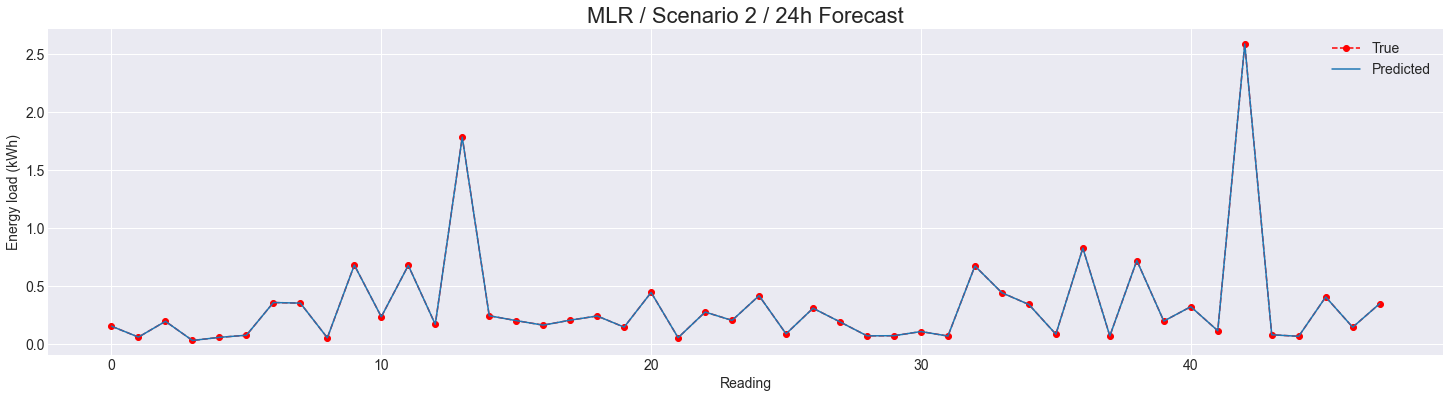

In [25]:
matplotlib.rcParams.update({'font.size': 14})
predicted_mreg = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_mreg['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_mreg['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('MLR / Scenario 2 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario2/1_allHouseholds/S2_24h_MLR.jpeg', dpi = 500)
plt.show()


The model is predicting almost perfectly.

In [ ]:
from joblib import dump, load
dump(model, 'C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/MLR_Scenario2.joblib')

['C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/MLR_Scenario2.joblib']

### support vector regressor (SVR)

In [26]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR

In [27]:
model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

Training time: 0.215 s


**Prediction**

In [28]:
# make a prediction
yhat = model.predict(test_X)

In [29]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999994821608859
Mse:  0.000001005614815
Rmse: 0.001002803477904
Mae:  0.000719112510737
Mape:  0.462516944786899
Training time: 0.215 s


In [30]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

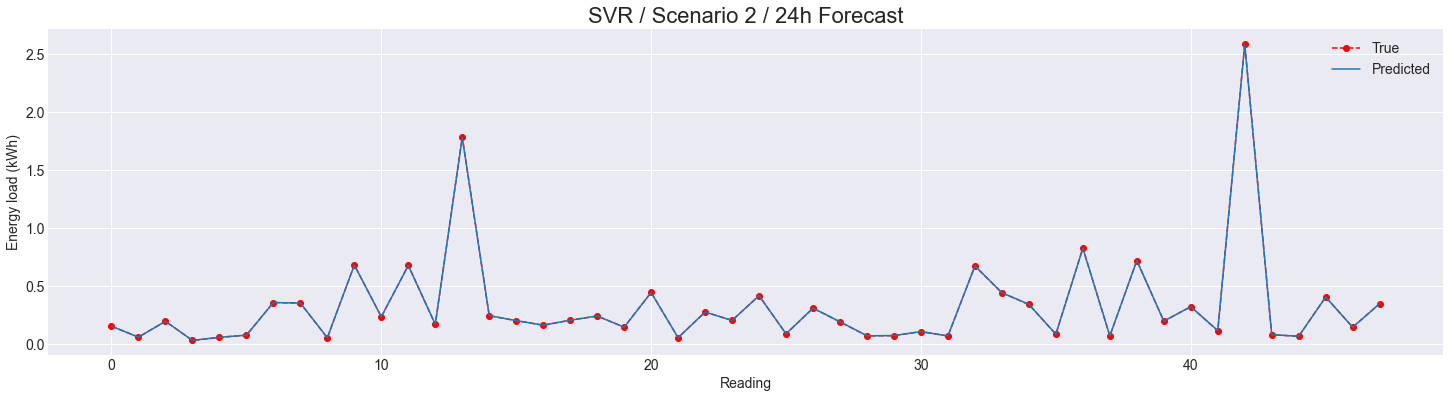

In [31]:
matplotlib.rcParams.update({'font.size': 14})
predicted_svm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_svm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_svm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('SVR / Scenario 2 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario2/1_allHouseholds/S2_24h_SVR.jpeg', dpi = 500)
plt.show()

Although the model picked up on the general trend, it clearly lacks the performance of the MLR.

In [32]:
from joblib import dump, load
dump(model, 'C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/SVR_Scenario2.joblib')

['C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/SVR_Scenario2.joblib']

### random forest (RF)

In [33]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [34]:
model = RandomForestRegressor(bootstrap= True,
                              max_depth= 110,
                              max_features= 0.33,
                              min_samples_leaf= 3,
                              min_samples_split= 10,
                              n_estimators= 100, 
                              criterion='mse')
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

Training time: 25.050 s


**Prediction**

In [35]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.reshape(yhat.shape[0],1)

**Prediction**

In [36]:
# make a prediction
yhat = model.predict(test_X)

In [37]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.946635169926296
Mse:  0.007365184116342
Rmse: 0.085820650873449
Mae:  0.022984579279139
Mape:  6.521076247987286
Training time: 25.050 s


In [38]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

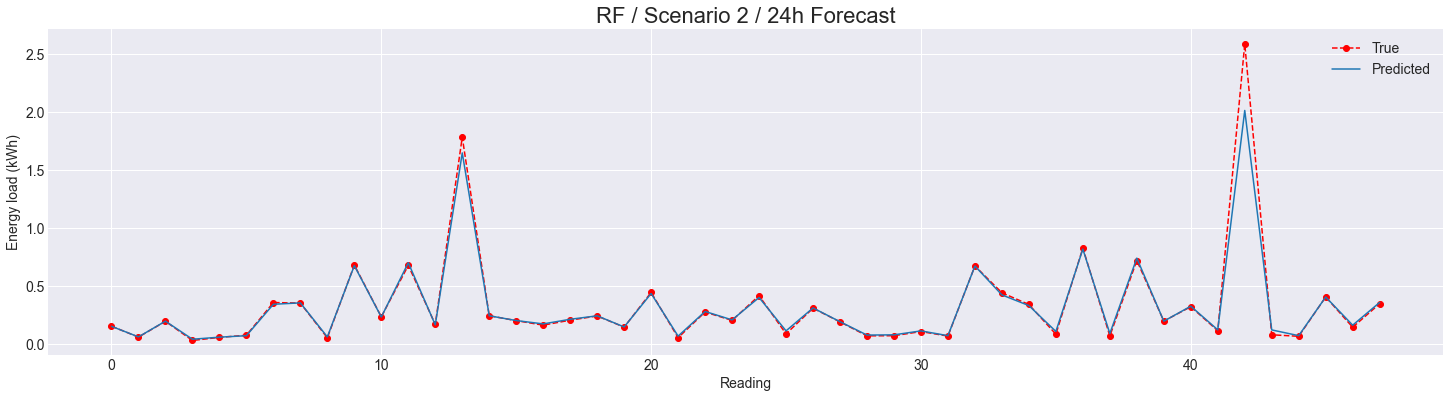

In [39]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rf = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rf['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rf['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RF / Scenario 2 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario2/1_allHouseholds/S2_24h_RF.jpeg', dpi = 500)
plt.show()

The model is predicting very well, picking up on very fine energy consumption trends

### feedforward neural networks (FFNNs)

Data must be reshaped for the neural networks models to work

In [40]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(39480, 1, 39) (39480,) (48, 1, 39) (48,)


In [41]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers import GRU
from keras.layers.convolutional import MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.layers import TimeDistributed
import keras
from keras import layers

In [42]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [43]:
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [44]:
from keras.optimizers import RMSprop

Epoch 1/10
7896/7896 - 4s - loss: 0.0070
Epoch 2/10
7896/7896 - 5s - loss: 6.6544e-04
Epoch 3/10
7896/7896 - 5s - loss: 3.8976e-04
Epoch 4/10
7896/7896 - 5s - loss: 2.7609e-04
Epoch 5/10
7896/7896 - 5s - loss: 2.1415e-04
Epoch 6/10
7896/7896 - 5s - loss: 1.7626e-04
Epoch 7/10
7896/7896 - 4s - loss: 1.5088e-04
Epoch 8/10
7896/7896 - 4s - loss: 1.3150e-04
Epoch 9/10
7896/7896 - 4s - loss: 1.1945e-04
Epoch 10/10
7896/7896 - 5s - loss: 1.1232e-04


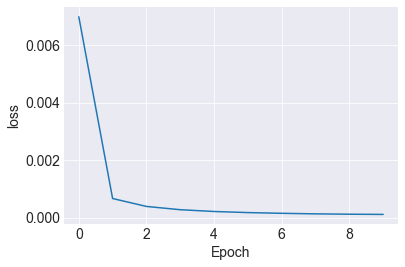

Training time: 46.772 s


In [45]:
model = Sequential()

# Add fully connected layer with a ReLU activation function
model.add(Dense(units=64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(units=64, activation='relu'))

# Add fully connected layer with no activation function
model.add(Dense(units=1))

optimizer = keras.optimizers.RMSprop(lr=0.001, momentum= 0.9)

model.compile(loss='mean_squared_error', # Mean squared error
            optimizer ='RMSprop' # Optimization algorithm
            )

start_time = time.time()
history = model.fit(train_X, train_y, epochs=10, batch_size=5, verbose=2, shuffle=False) 
end_time = time.time()
train_time = end_time - start_time
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [46]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [47]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999365953827380
Mse:  0.000121900796910
Rmse: 0.011040869391027
Mae:  0.010293542252233
Mape:  7.033827739785591
Training time: 46.772 s


In [48]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

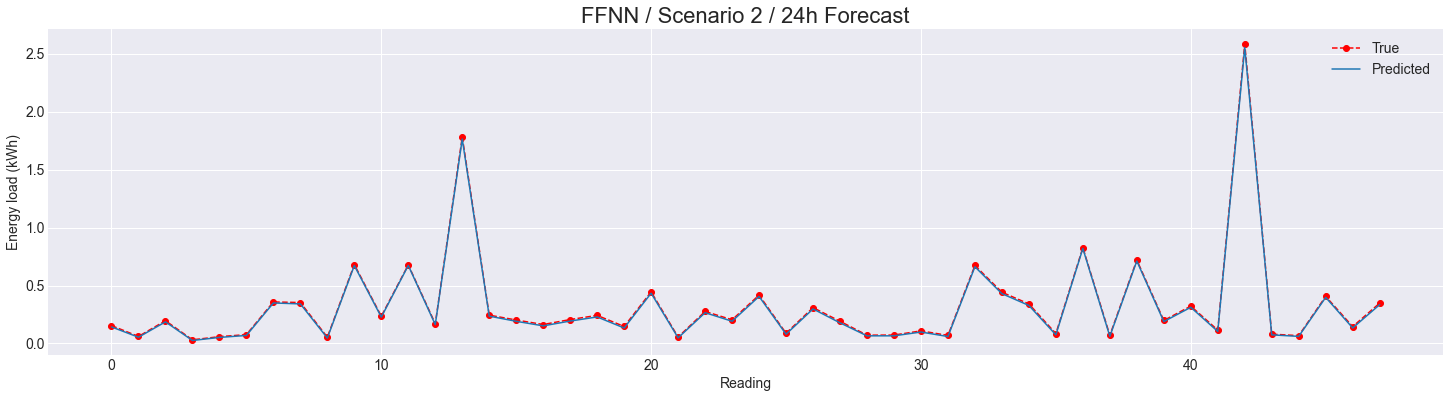

In [49]:
matplotlib.rcParams.update({'font.size': 14})
predicted_fnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_fnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_fnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('FFNN / Scenario 2 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario2/1_allHouseholds/S2_24h_FFNN.jpeg', dpi = 500)
plt.show()

Good predictions, although a bit worse compared to the RF.

### LSTM

This model is just like the previous one, however without the CNN applied before it. Unlike regular FFNNs, a LSTM network involves backward looking and weights "memorisation"

Reference: https://en.wikipedia.org/wiki/Long_short-term_memory

In [50]:
from keras.wrappers.scikit_learn import KerasRegressor
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [51]:
from keras.optimizers import Adam

Epoch 1/30
1645/1645 - 2s - loss: 0.0329
Epoch 2/30
1645/1645 - 2s - loss: 9.4498e-04
Epoch 3/30
1645/1645 - 2s - loss: 8.6066e-04
Epoch 4/30
1645/1645 - 2s - loss: 6.1359e-04
Epoch 5/30
1645/1645 - 2s - loss: 1.3312e-04
Epoch 6/30
1645/1645 - 2s - loss: 2.5782e-04
Epoch 7/30
1645/1645 - 2s - loss: 3.2908e-04
Epoch 8/30
1645/1645 - 2s - loss: 2.0455e-04
Epoch 9/30
1645/1645 - 2s - loss: 2.9018e-04
Epoch 10/30
1645/1645 - 2s - loss: 2.5842e-04
Epoch 11/30
1645/1645 - 2s - loss: 2.3133e-04
Epoch 12/30
1645/1645 - 2s - loss: 2.2966e-04
Epoch 13/30
1645/1645 - 2s - loss: 2.1994e-04
Epoch 14/30
1645/1645 - 2s - loss: 1.8043e-04
Epoch 15/30
1645/1645 - 2s - loss: 2.9196e-04
Epoch 16/30
1645/1645 - 2s - loss: 2.1574e-04
Epoch 17/30
1645/1645 - 2s - loss: 1.3569e-04
Epoch 18/30
1645/1645 - 2s - loss: 3.9906e-04
Epoch 19/30
1645/1645 - 2s - loss: 1.0004e-04
Epoch 20/30
1645/1645 - 2s - loss: 3.3872e-04
Epoch 21/30
1645/1645 - 2s - loss: 8.2846e-05
Epoch 22/30
1645/1645 - 2s - loss: 1.5016e-04
E

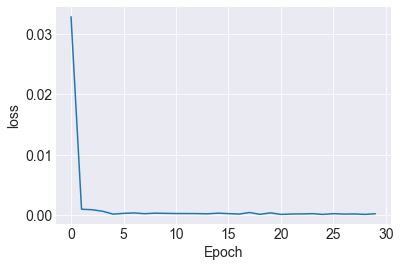

Training time: 57.307 s


In [52]:
# design network
model = Sequential()
model.add(LSTM(128,  activation='softplus', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )


start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [53]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [54]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999941952124710
Mse:  0.000011338585926
Rmse: 0.003367281682070
Mae:  0.002989650626356
Mape:  3.016370802680074
Training time: 57.307 s


In [55]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

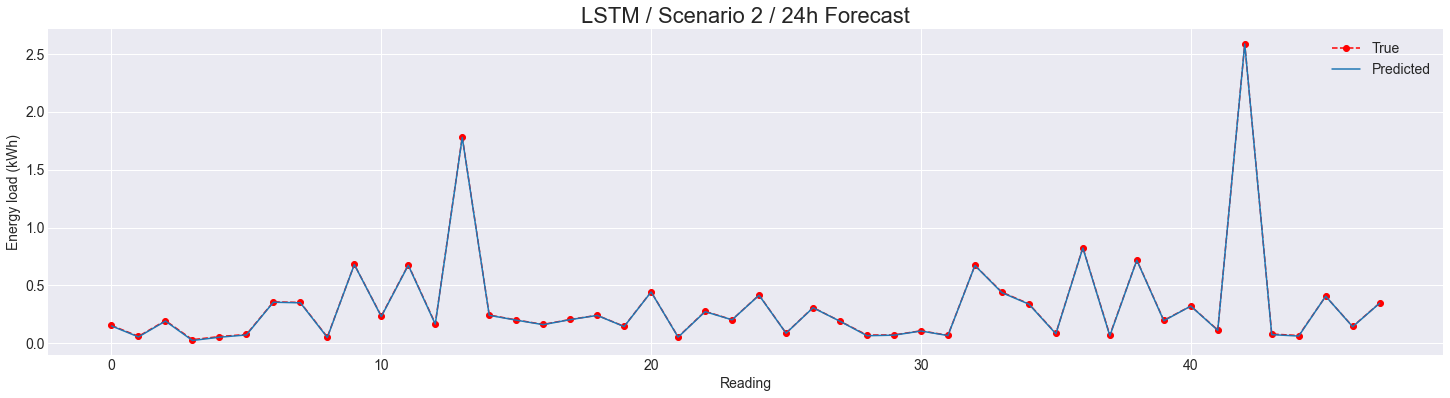

In [56]:
matplotlib.rcParams.update({'font.size': 14})
predicted_lstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_lstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_lstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('LSTM / Scenario 2 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario2/1_allHouseholds/S2_24h_LSTM.jpeg', dpi = 500)
plt.show()

The model is doing well, better than the previous NN, however not as good as MLR and RF.

### RNN

In [57]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Epoch 1/30
1645/1645 - 1s - loss: 0.0219
Epoch 2/30
1645/1645 - 2s - loss: 4.8611e-04
Epoch 3/30
1645/1645 - 2s - loss: 9.7934e-04
Epoch 4/30
1645/1645 - 2s - loss: 2.2971e-04
Epoch 5/30
1645/1645 - 2s - loss: 4.9635e-04
Epoch 6/30
1645/1645 - 1s - loss: 3.7312e-04
Epoch 7/30
1645/1645 - 1s - loss: 5.0387e-04
Epoch 8/30
1645/1645 - 1s - loss: 1.7304e-04
Epoch 9/30
1645/1645 - 1s - loss: 3.1136e-04
Epoch 10/30
1645/1645 - 1s - loss: 1.6246e-04
Epoch 11/30
1645/1645 - 1s - loss: 2.4984e-04
Epoch 12/30
1645/1645 - 1s - loss: 3.9289e-04
Epoch 13/30
1645/1645 - 1s - loss: 2.1077e-04
Epoch 14/30
1645/1645 - 1s - loss: 2.1664e-04
Epoch 15/30
1645/1645 - 1s - loss: 1.8803e-04
Epoch 16/30
1645/1645 - 1s - loss: 2.1749e-04
Epoch 17/30
1645/1645 - 1s - loss: 1.8270e-04
Epoch 18/30
1645/1645 - 1s - loss: 5.5629e-05
Epoch 19/30
1645/1645 - 1s - loss: 2.3228e-04
Epoch 20/30
1645/1645 - 1s - loss: 5.1953e-05
Epoch 21/30
1645/1645 - 1s - loss: 1.8783e-04
Epoch 22/30
1645/1645 - 1s - loss: 5.9140e-05
E

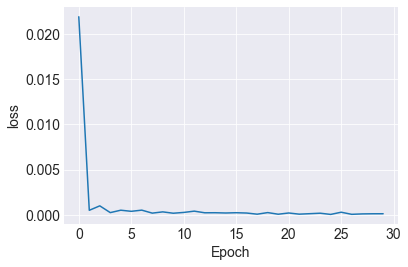

Training time: 41.760 s


In [58]:
# design network
model = Sequential()
model.add(SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )


start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

In [59]:
model.save('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario2.h5')

In [60]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario2.h5")
print("Saved model to disk")
 

Saved model to disk


In [61]:
from keras.models import model_from_json


In [62]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario2.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data


Loaded model from disk


**Prediction**

In [63]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [64]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999823777368899
Mse:  0.000033803871824
Rmse: 0.005814109718935
Mae:  0.002917523107802
Mape:  1.232567954792545
Training time: 41.760 s


In [65]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

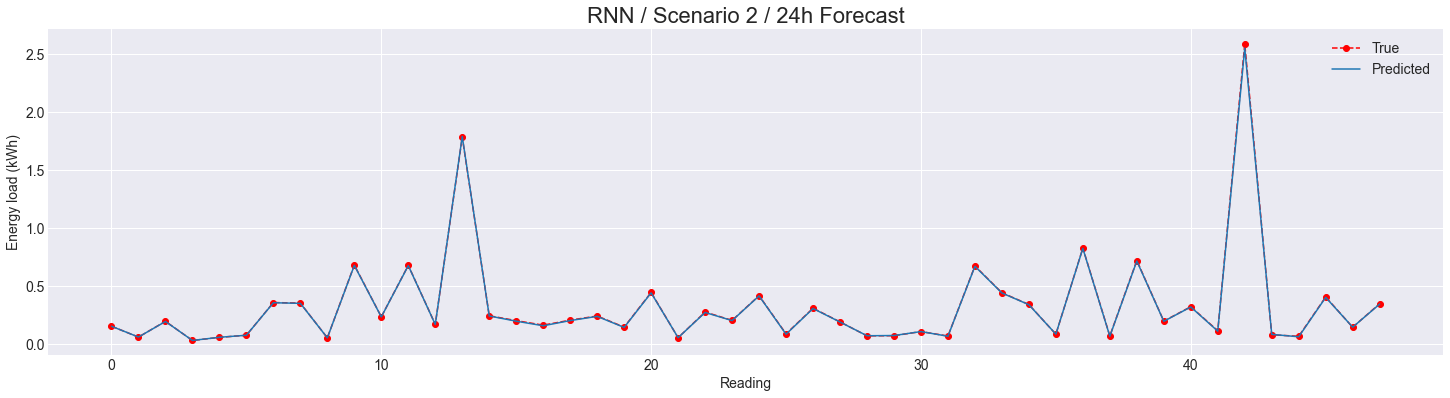

In [66]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN / Scenario 2 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario2/1_allHouseholds/S2_24h_RNN.jpeg', dpi = 500)
plt.show()

The model is doing well however its accuracy is worse than that of CNN-LSTM. However, it's training 4 times faster. 

Because this model achieved the best performance, saving it:

### Dense + LSTM

*In* order to fully leverage the neural network achitecture, an LSTM layer is combined with two dense ones. 

Epoch 1/30
617/617 - 1s - loss: 0.0795
Epoch 2/30
617/617 - 1s - loss: 0.0251
Epoch 3/30
617/617 - 1s - loss: 0.0015
Epoch 4/30
617/617 - 1s - loss: 7.9820e-04
Epoch 5/30
617/617 - 2s - loss: 7.3525e-04
Epoch 6/30
617/617 - 1s - loss: 6.4070e-04
Epoch 7/30
617/617 - 1s - loss: 6.0631e-04
Epoch 8/30
617/617 - 1s - loss: 5.4750e-04
Epoch 9/30
617/617 - 1s - loss: 5.1311e-04
Epoch 10/30
617/617 - 1s - loss: 4.5999e-04
Epoch 11/30
617/617 - 1s - loss: 4.4173e-04
Epoch 12/30
617/617 - 2s - loss: 3.8915e-04
Epoch 13/30
617/617 - 2s - loss: 3.8828e-04
Epoch 14/30
617/617 - 1s - loss: 3.4902e-04
Epoch 15/30
617/617 - 1s - loss: 3.3859e-04
Epoch 16/30
617/617 - 2s - loss: 3.0163e-04
Epoch 17/30
617/617 - 1s - loss: 2.7632e-04
Epoch 18/30
617/617 - 2s - loss: 2.6238e-04
Epoch 19/30
617/617 - 1s - loss: 3.1317e-04
Epoch 20/30
617/617 - 1s - loss: 2.2860e-04
Epoch 21/30
617/617 - 1s - loss: 2.5081e-04
Epoch 22/30
617/617 - 1s - loss: 2.2253e-04
Epoch 23/30
617/617 - 1s - loss: 2.6345e-04
Epoch 24/

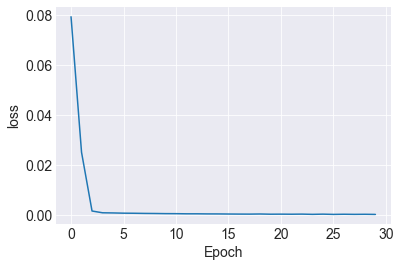

Training time: 43.248 s


In [67]:
# design network
model = Sequential()
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(LSTM(128))
model.add(Dense(1))
optimizer = Adam(lr=0.0001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )

#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc']) #mae

start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=64, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

In [68]:
model.save('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/dense_LSTM_Scenario2_24h.h5')

**Prediction**

In [69]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [70]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999417187718758
Mse:  0.000110912494194
Rmse: 0.010531500092288
Mae:  0.007897960216117
Mape:  4.691948485358085
Training time: 43.248 s


In [71]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

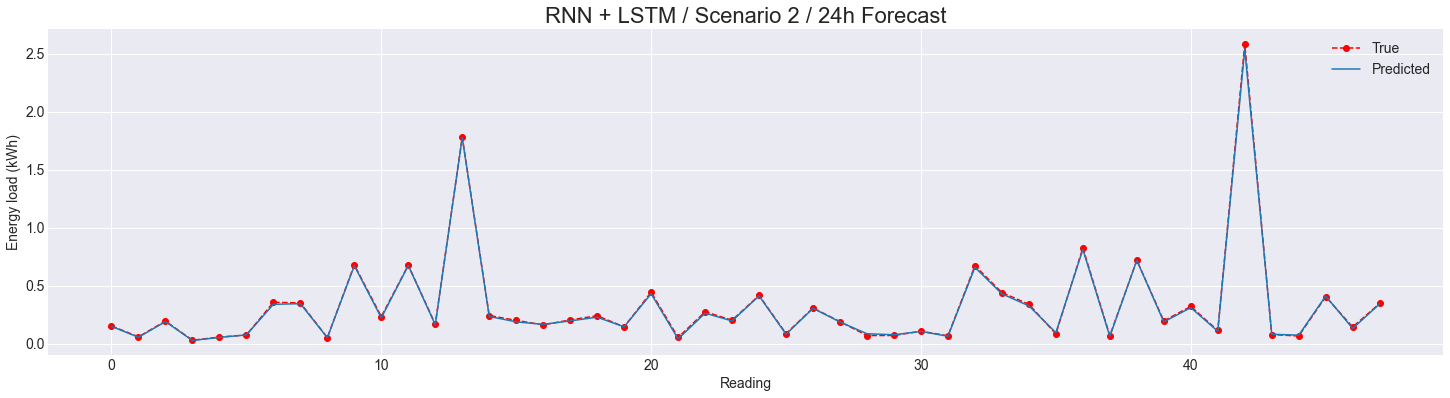

In [72]:
matplotlib.rcParams.update({'font.size': 14})
predicted_denselstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_denselstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_denselstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN + LSTM / Scenario 2 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario2/1_allHouseholds/S2_24h_RNN_LSTM.jpeg', dpi = 500)
plt.show()

This is the best model, the predictions accurately follow the observed energy consumption.


## Best model

In [ ]:
models_performances = pd.DataFrame([R2_scores,MSE_scores,RMSE_scores,MAE_scores,MAPE_scores,train_times],
                                   columns=models_predictions, 
                                   index=['R2_scores', 'MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores', 'Train_Time'])
models_performances

,MLR,SVM,RF,FFNNs,LSTM,RNN,Dense+LSTM
R2_scores,1.000000e+00,0.999995,0.946635,0.999612,0.999887,0.999151,0.999245
MSE_scores,1.038068e-16,0.000001,0.007365,0.000076,0.000022,0.000158,0.000147
RMSE_scores,1.018856e-08,0.001003,0.085821,0.008727,0.004693,0.012581,0.012130
MAE_scores,6.249459e-09,0.000719,0.022985,0.007844,0.004377,0.003228,0.007777
MAPE_scores,1.998714e-06,0.462517,6.521076,5.530762,3.928505,1.025722,5.127464
Train_Time,3.889465e-02,0.225396,23.464303,44.099261,55.378953,38.249746,39.982112


In [ ]:
models_performances.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/BestModel_Scenario2.csv', index=False)

**Plotting all models together.**

In [73]:
prev_day = train_y[-48:] #energy readings from previous day
y_plotting = np.concatenate([prev_day, test_y], axis=0)

In [74]:

# Get all predictions from the models
predicted_energy=[predicted_mreg['predicted'],
                  predicted_svm['predicted'],
                  predicted_rf['predicted'],
                  predicted_fnn['predicted'],
                  predicted_lstm['predicted'],
                  predicted_rnn['predicted'],
                  predicted_denselstm['predicted']]

In [75]:
prev_2days = sorted(pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario2.csv').time)[-96:]

In [76]:
df_for_plotting = pd.DataFrame(y_plotting, index=prev_2days, columns=['Original'])

In [77]:
# Initialize all columns with null values
df_for_plotting["Train"] = np.nan
# Add a column for each model's predictions
col_names=['MLR', 'SVR', 'RF', 'FFNN', 'LSTM', 'RNN', 'Dense-LSTM']
for col_name in col_names:
  df_for_plotting[col_name+' forecast'] = np.nan

In [78]:
# Fill in with corresponding values
df_for_plotting["Train"][:-48] = prev_day

for i, model_pred in enumerate(predicted_energy):
  df_for_plotting[col_names[i]+' forecast'][-48:] = model_pred

In [79]:
# Turn index to datetime
df_for_plotting.index = pd.to_datetime(df_for_plotting.index)

In [80]:
df_for_plotting.columns

Index(['Original', 'Train', 'MLR forecast', 'SVR forecast', 'RF forecast',
       'FFNN forecast', 'LSTM forecast', 'RNN forecast',
       'Dense-LSTM forecast'],
      dtype='object')

In [81]:
import datetime
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

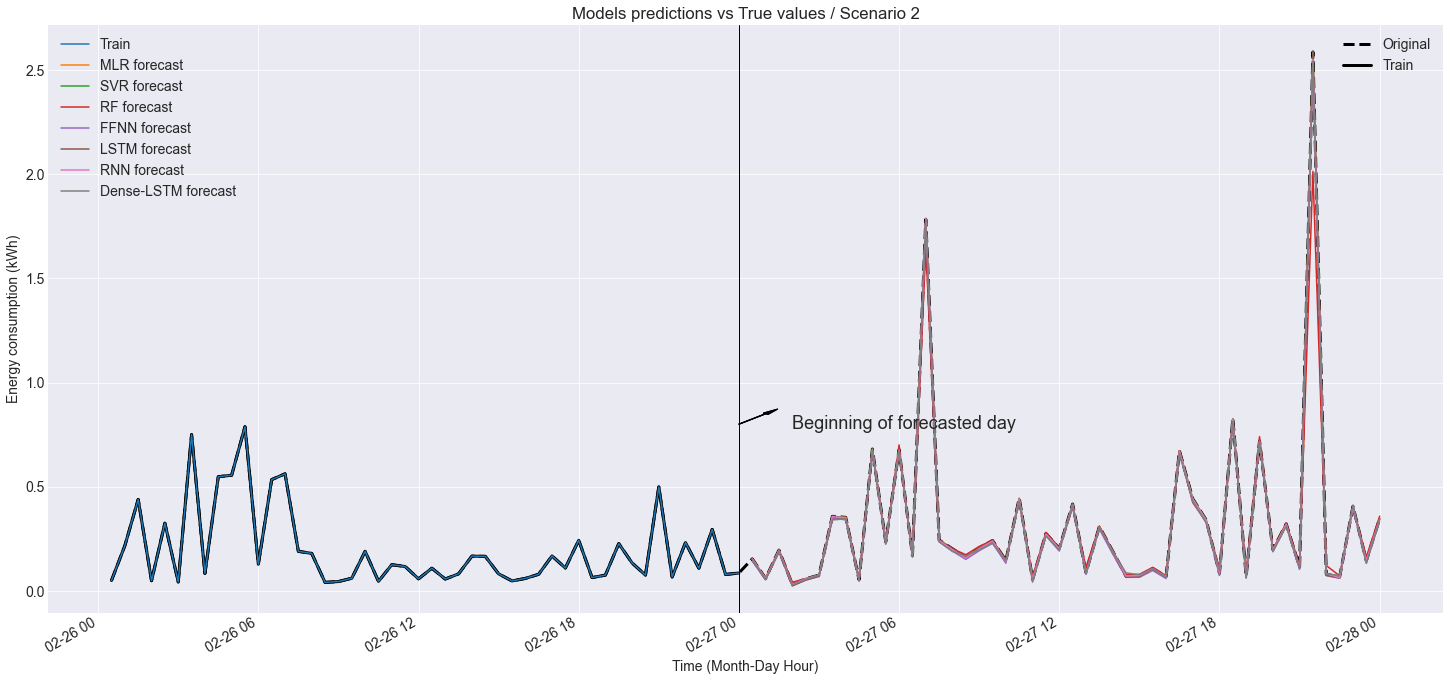

In [82]:
import matplotlib.dates as md

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)


# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='K', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[1:]:
  df_for_plotting[forecast].plot(label=forecast)

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00:00')
plt.text(label_x_pos, 0.8, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)


# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.8, dx, 0.05, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)


plt.title('Models predictions vs True values / Scenario 2')

plt.legend()
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario2/1_allHouseholds/S2_24h_OriginalPredicted_All.jpeg', dpi = 500)
plt.show()

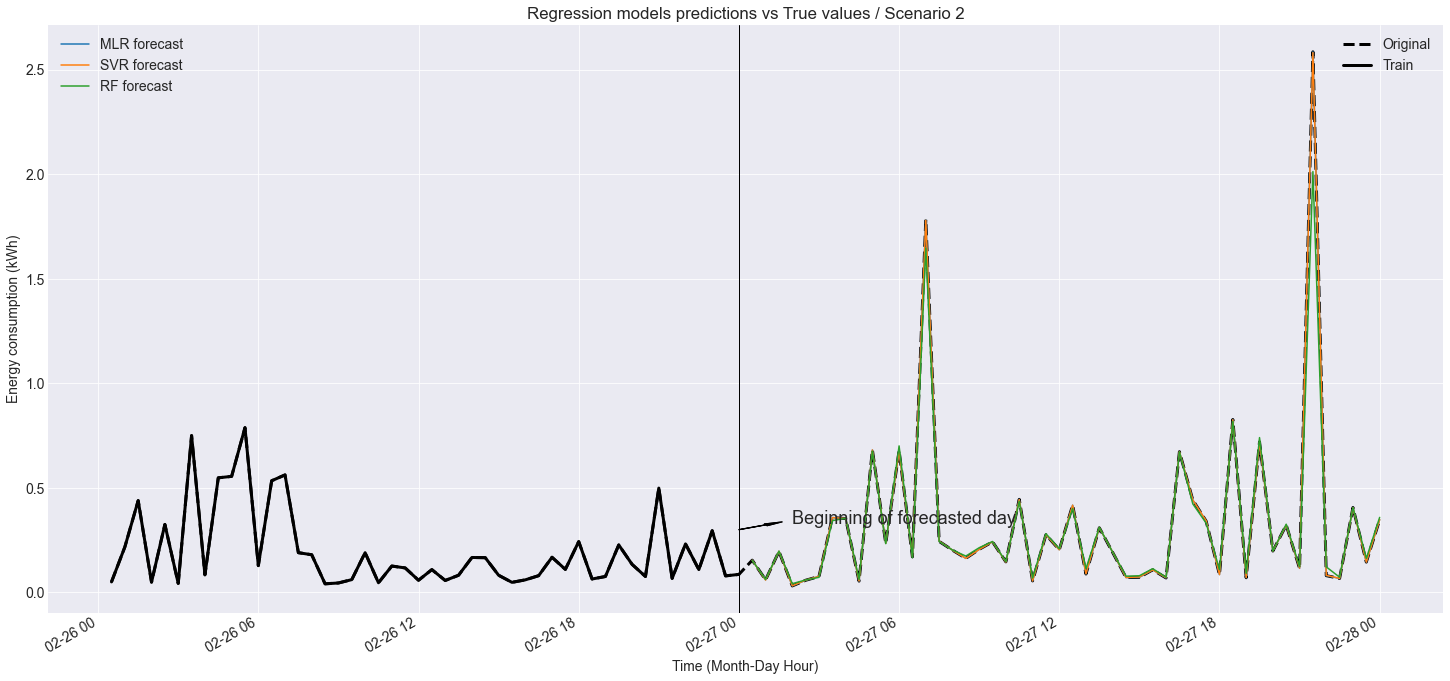

In [83]:
import matplotlib.dates as md

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='k', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[2:5]:
  df_for_plotting[forecast].plot(label=forecast)

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00')
plt.text(label_x_pos, 0.35, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)

# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.3, dx, 0.023, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)

plt.title('Regression models predictions vs True values / Scenario 2')

plt.legend()
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario2/1_allHouseholds/S2_24h_RegressionModelsPredicted_All.jpeg', dpi = 500)
plt.show()

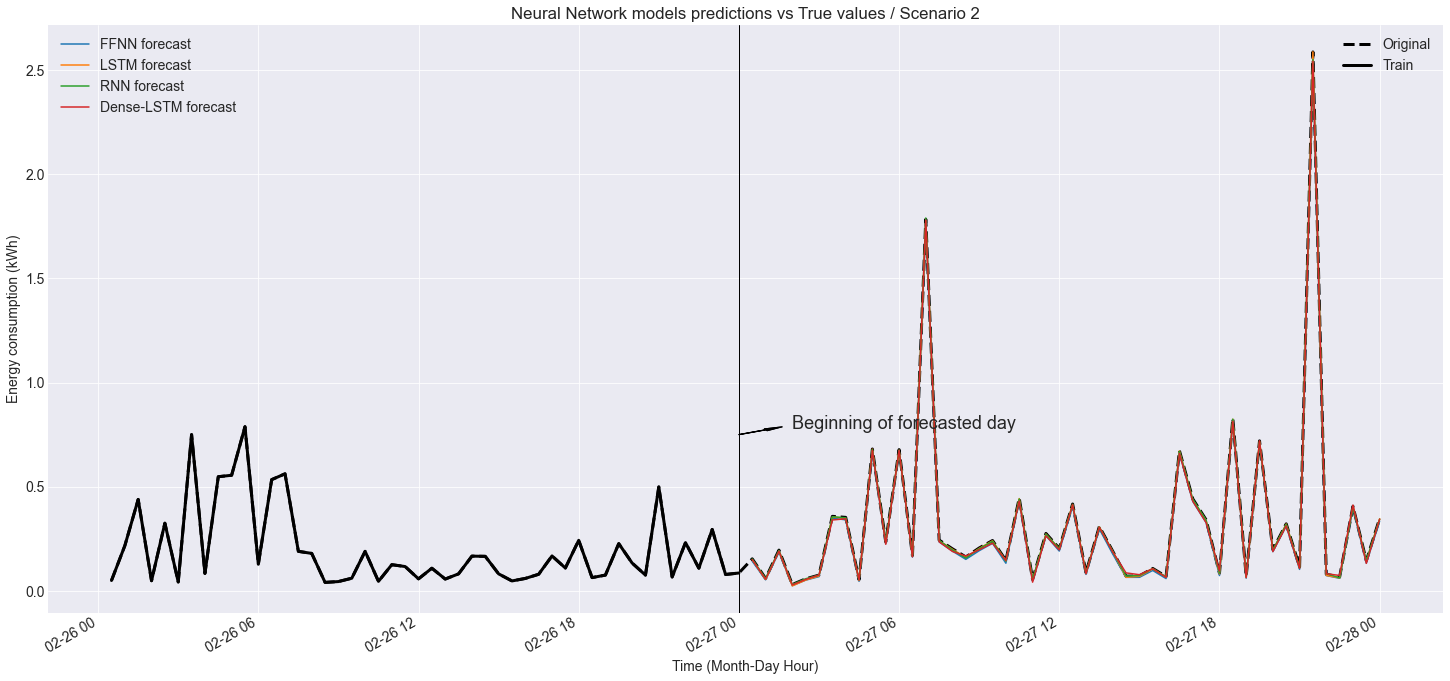

In [84]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='k', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[5:]:
  df_for_plotting[forecast].plot()

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00')
plt.text(label_x_pos, 0.8, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)

# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.75, dx, 0.023, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)

plt.title('Neural Network models predictions vs True values / Scenario 2')
plt.legend(loc='upper left')
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario2/1_allHouseholds/S2_24h_OriginalPredicted_4_8.jpeg', dpi = 500)
plt.show()

## House level prediction 
-For each half hour, for each of the 33 types.

In [85]:
houses_data = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/all_houses_Scenario4.csv')

In [ ]:
houses_data

,LCLid,tstp,energy(kWh/hh)
0,2,2012-10-12 00:30:00,0.000
1,2,2012-10-12 01:00:00,0.000
2,2,2012-10-12 01:30:00,0.000
3,2,2012-10-12 02:00:00,0.000
4,2,2012-10-12 02:30:00,0.000
...,...,...,...
8092712,5124,2014-02-27 22:00:00,0.673
8092713,5124,2014-02-27 22:30:00,0.590
8092714,5124,2014-02-27 23:00:00,0.552
8092715,5124,2014-02-27 23:30:00,0.519


In [86]:
houses_data.rename(columns={'tstp':'time'}, inplace=True)

Merging with the weather_energy data

In [87]:
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario4.csv')

In [88]:
weather_energy.columns

Index(['time', 'year', 'month', 'day', 'hour', 'weekday', 'energy(kWh/hh)',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped', 'weekend'],
      dtype='object')

In [89]:
weather_energy = weather_energy.drop(columns = ['holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped'])

In [90]:
updated_houses = houses_data.merge(weather_energy, on='time')

In [91]:
updated_houses

,LCLid,time,energy(kWh/hh)_x,year,month,day,hour,weekday,energy(kWh/hh)_y,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,weekend
0,2,2012-10-12 00:30:00,0.000,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0
1,246,2012-10-12 00:30:00,0.975,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0
2,1074,2012-10-12 00:30:00,1.438,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0
3,3281,2012-10-12 00:30:00,0.078,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0
4,3305,2012-10-12 00:30:00,0.101,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8086036,183,2011-12-03 06:30:00,0.109,2011,12,3,6,5,0.109,11.73,244,11.00,10.26,1001.07,11.00,6.37,0.95,1
8086037,183,2011-12-03 07:00:00,0.030,2011,12,3,7,5,0.030,11.93,253,10.96,9.73,1001.07,10.96,5.48,0.92,1
8086038,183,2011-12-03 07:30:00,0.082,2011,12,3,7,5,0.082,11.93,253,10.96,9.73,1001.07,10.96,5.48,0.92,1
8086039,183,2011-12-03 08:00:00,0.030,2011,12,3,8,5,0.030,13.71,253,11.01,9.11,1001.55,11.01,6.32,0.88,1


In [92]:
updated_houses.columns

Index(['LCLid', 'time', 'energy(kWh/hh)_x', 'year', 'month', 'day', 'hour',
       'weekday', 'energy(kWh/hh)_y', 'visibility', 'windBearing',
       'temperature', 'dewPoint', 'pressure', 'apparentTemperature',
       'windSpeed', 'humidity', 'weekend'],
      dtype='object')

In [93]:
updated_houses.columns = ['LCLid', 'time', 'energy(kWh/hh)', 'year', 'month', 'day', 'hour',
       'weekday', 'energy(kWh/hh)_y', 'visibility', 'windBearing',
       'temperature', 'dewPoint', 'pressure', 'apparentTemperature',
       'windSpeed', 'humidity', 'weekend']

In [ ]:
updated_houses.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S2.csv')

In [95]:
updated_houses = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S2.csv')

In [96]:
updated_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7071935 entries, 0 to 7071934
Data columns (total 19 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Unnamed: 0           int64  
 1   LCLid                int64  
 2   time                 object 
 3   energy(kWh/hh)       float64
 4   year                 int64  
 5   month                int64  
 6   day                  int64  
 7   hour                 int64  
 8   weekday              int64  
 9   energy(kWh/hh)_y     float64
 10  visibility           float64
 11  windBearing          int64  
 12  temperature          float64
 13  dewPoint             float64
 14  pressure             float64
 15  apparentTemperature  float64
 16  windSpeed            float64
 17  humidity             float64
 18  weekend              int64  
dtypes: float64(9), int64(9), object(1)
memory usage: 1.0+ GB


In [97]:
updated_houses.columns

Index(['Unnamed: 0', 'LCLid', 'time', 'energy(kWh/hh)', 'year', 'month', 'day',
       'hour', 'weekday', 'energy(kWh/hh)_y', 'visibility', 'windBearing',
       'temperature', 'dewPoint', 'pressure', 'apparentTemperature',
       'windSpeed', 'humidity', 'weekend'],
      dtype='object')

In [98]:
updated_houses[updated_houses.LCLid==2]

,Unnamed: 0,LCLid,time,energy(kWh/hh),year,month,day,hour,weekday,energy(kWh/hh)_y,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,weekend
0,0,2,2012-10-12 00:30:00,0.000,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0
258,258,2,2012-10-12 01:00:00,0.000,2012,10,12,1,4,0.094,13.50,250,13.09,11.37,1000.10,13.09,6.77,0.89,0
516,516,2,2012-10-12 01:30:00,0.000,2012,10,12,1,4,0.125,13.50,250,13.09,11.37,1000.10,13.09,6.77,0.89,0
774,774,2,2012-10-12 02:00:00,0.000,2012,10,12,2,4,0.081,13.50,252,12.54,10.27,1000.51,12.54,6.46,0.86,0
1032,1032,2,2012-10-12 02:30:00,0.000,2012,10,12,2,4,0.132,13.50,252,12.54,10.27,1000.51,12.54,6.46,0.86,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499697,6499697,2,2014-02-27 22:00:00,0.416,2014,2,27,22,3,0.171,14.00,216,4.10,1.64,1005.67,1.41,3.02,0.84,0
6499954,6499954,2,2014-02-27 22:30:00,1.350,2014,2,27,22,3,0.504,14.00,216,4.10,1.64,1005.67,1.41,3.02,0.84,0
6500211,6500211,2,2014-02-27 23:00:00,1.247,2014,2,27,23,3,0.176,14.03,200,3.93,1.61,1004.62,1.42,2.75,0.85,0
6500468,6500468,2,2014-02-27 23:30:00,1.218,2014,2,27,23,3,0.136,14.03,200,3.93,1.61,1004.62,1.42,2.75,0.85,0


Function to check another household:

In [99]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [100]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [101]:
from keras.models import Sequential, load_model
from joblib import dump, load


In [102]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                      'HH_2',
                      'HH_3',
                      'HH_4',
                      'HH_5',
                      'HH_6',
                      'HH_7',
                      'HH_8',
                      'HH_9',
                      'HH_10',
                      'HH_11',
                      'HH_12',
                      'HH_13',
                      'HH_14',
                      'HH_15',
                      'HH_16',
                      'HH_17',
                      'HH_18',
                      'HH_19',
                      'HH_20',
                      'HH_21',
                      'HH_22',
                      'HH_23',
                      'HH_24',
                      'HH_25',
                      'HH_26',
                      'HH_27',
                      'HH_28', 
                      'HH_29'] 

In [103]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-48), :]
  test = reframed[(len(reframed)-48):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  
  # Tranform the test set
  #train_X = scaler.fit_transform(train_X)
  #test_X = scaler.transform(test_X)

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))




  model = Sequential()
  model.add(SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))

  optimizer = Adam(lr=0.001)

  model.compile(loss='mean_squared_error', # Mean squared error
              optimizer = optimizer # Optimization algorithm
              )

  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15f}')
  print(f'Rmse: {rmse_HH:.15f}')
  print(f'Mae:  {mae_HH:.15f}')
  print(f'Mape:  {mape_HH:.15f}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /RNN (Scenario 2)')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario2/2_singleHouseholdLevel/best_NN_model/S2_24h_RNN_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


Mse:  1535.449580550540531
Rmse: 39.184813136603580
Mae:  39.125731321206935
Mape:  99.548174890511220


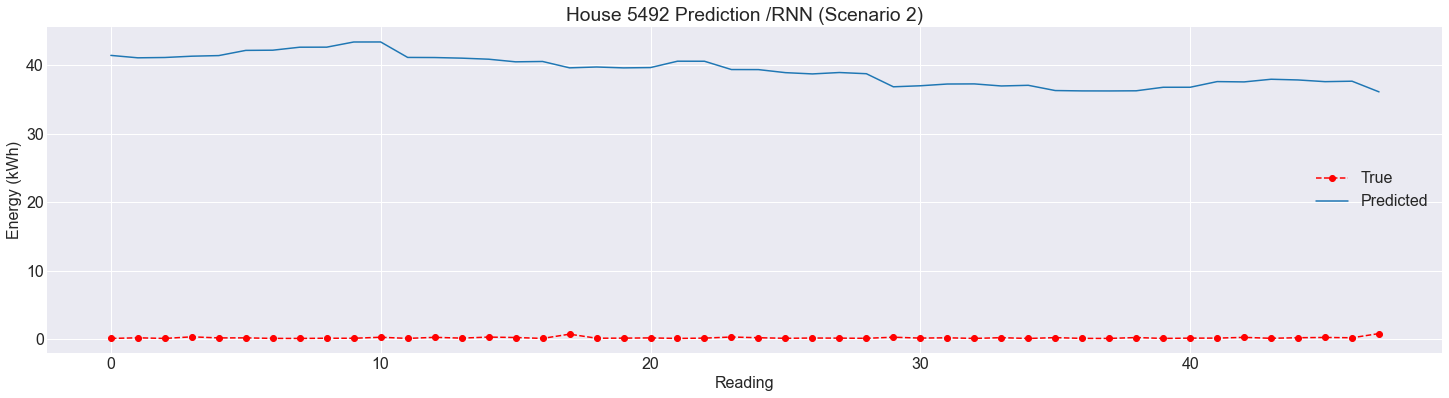

Mse:  20630.999970105582179
Rmse: 143.634953859099284
Mae:  143.613554153280944
Mape:  99.830176641469208


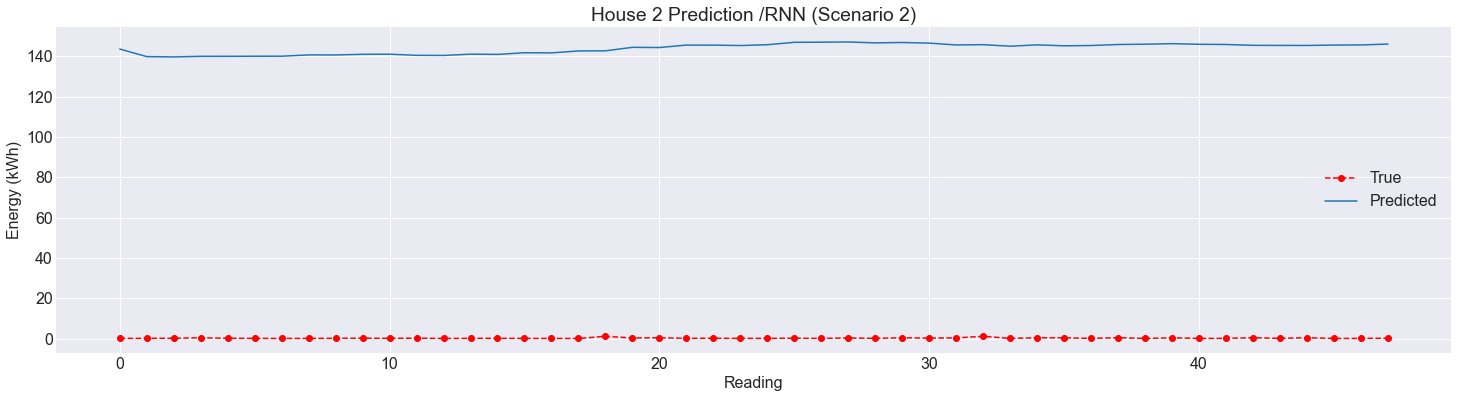

Mse:  300488.717760858125985
Rmse: 548.168512193885590
Mae:  548.140610551772056
Mape:  100.131158653108514


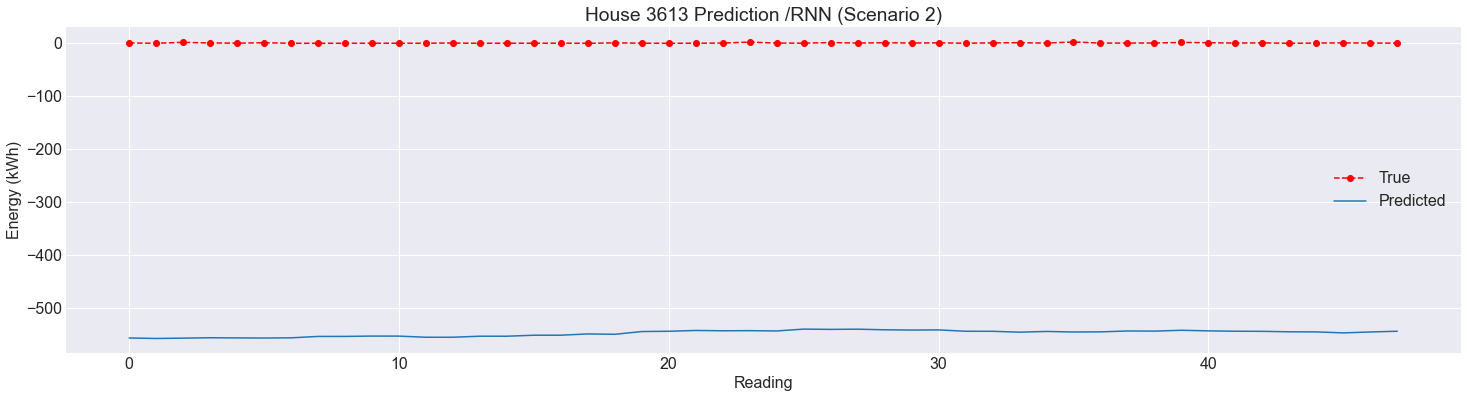

Mse:  126.767815979914317
Rmse: 11.259121456841751
Mae:  11.186708804646818
Mape:  98.560352147372853


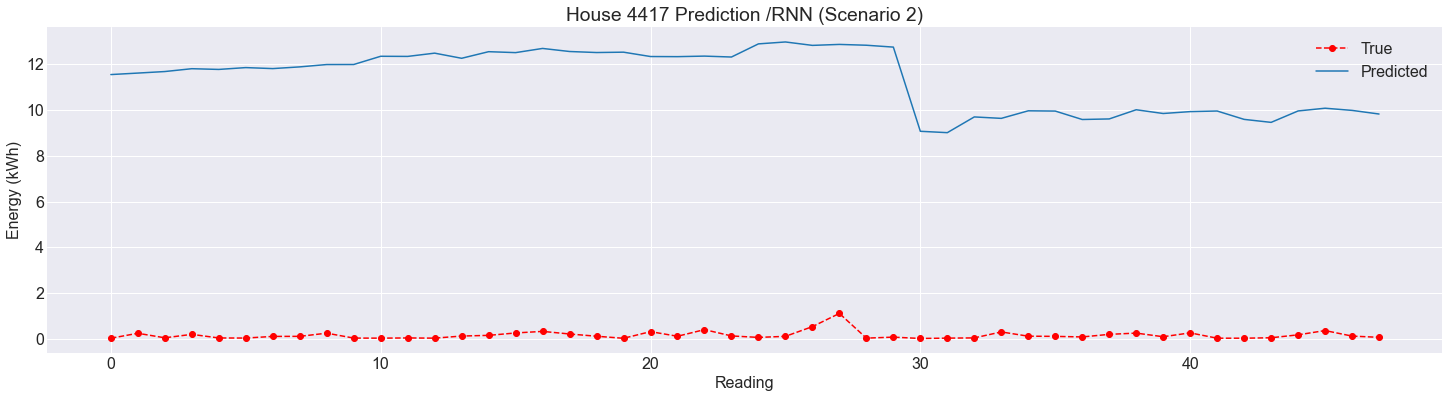

Mse:  2116.997203273075684
Rmse: 46.010837889274256
Mae:  45.991101576233632
Mape:  100.138373814119745


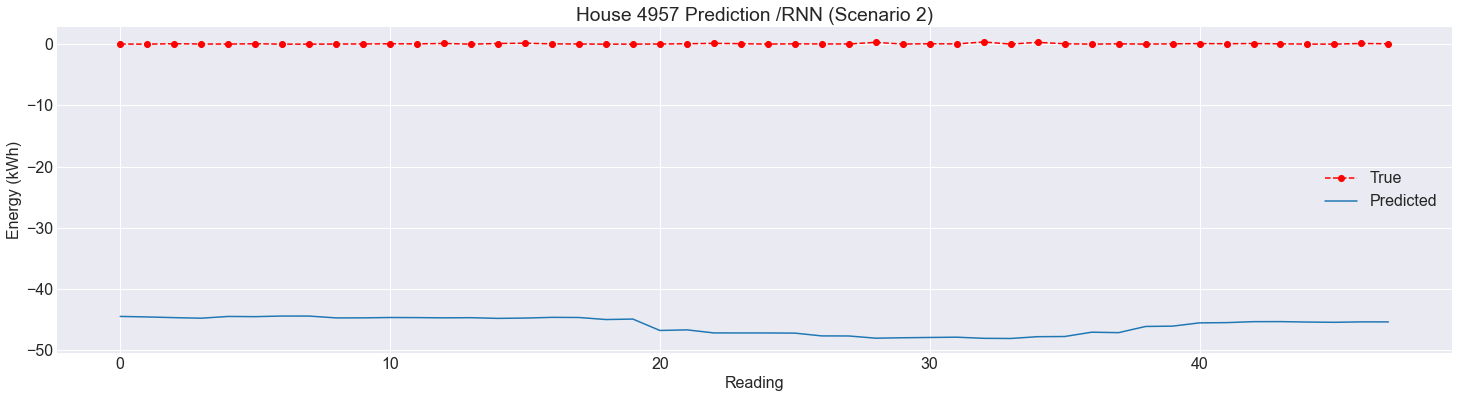

Mse:  1757.642434953838119
Rmse: 41.924246385043560
Mae:  41.875025491773464
Mape:  99.617712151459116


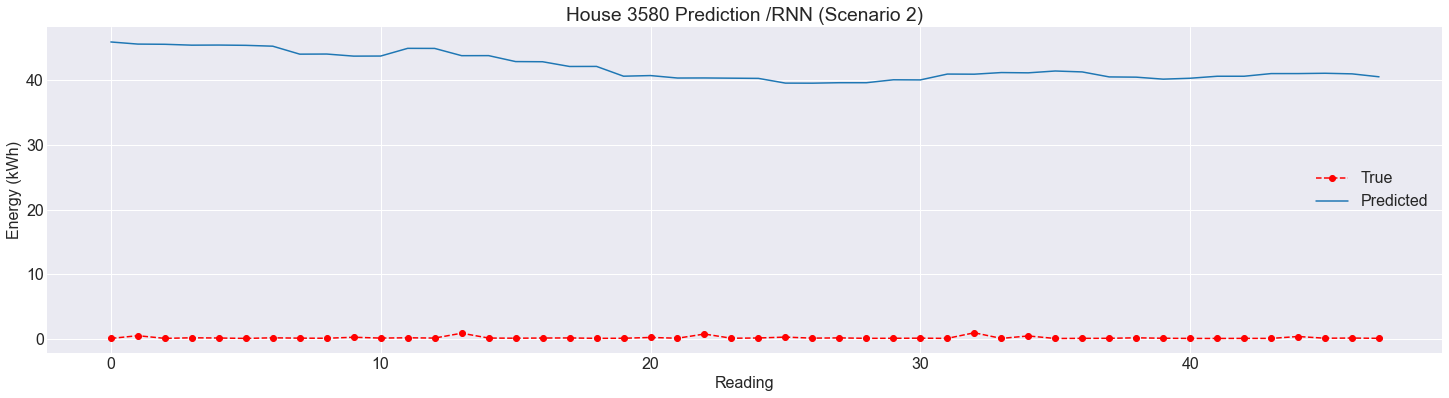

Mse:  2008.613578556124367
Rmse: 44.817558819687228
Mae:  44.793753286746018
Mape:  100.756145956684648


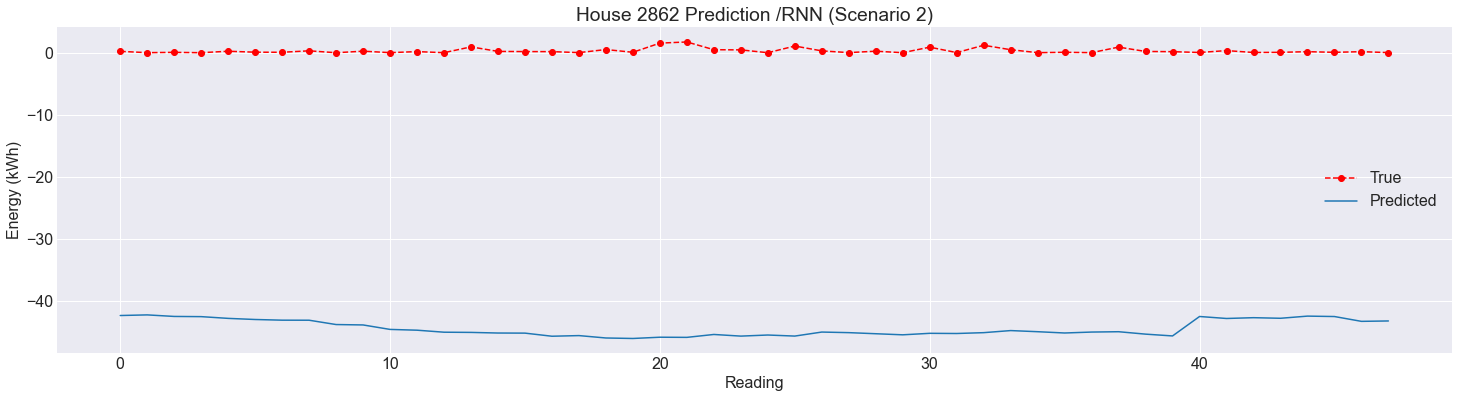

Mse:  39043.451315154721669
Rmse: 197.594158099764485
Mae:  197.583876208557427
Mape:  99.941519351208512


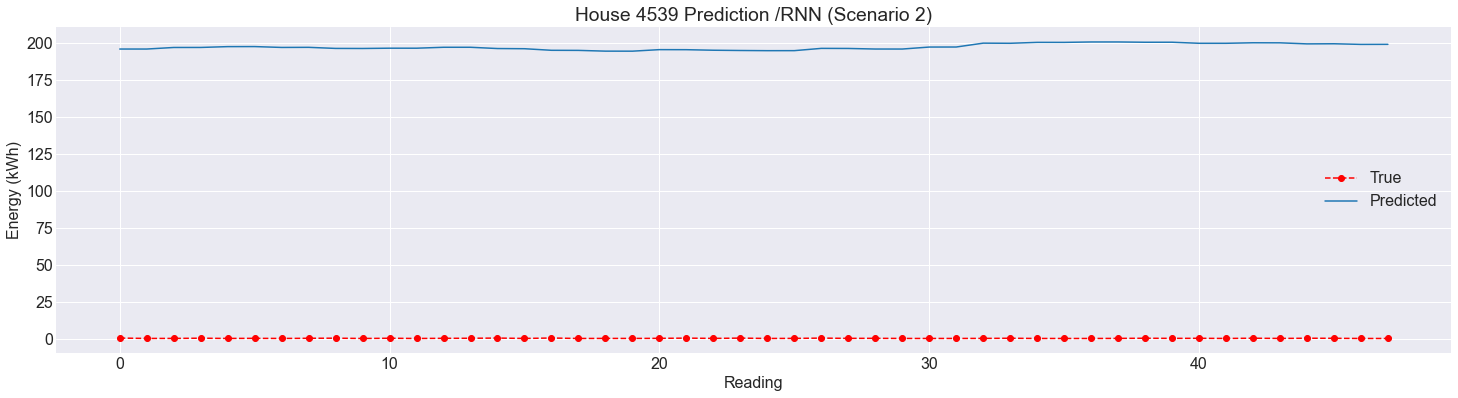

Mse:  22004.772636244524620
Rmse: 148.340057422951418
Mae:  148.283234150420554
Mape:  99.881636801719452


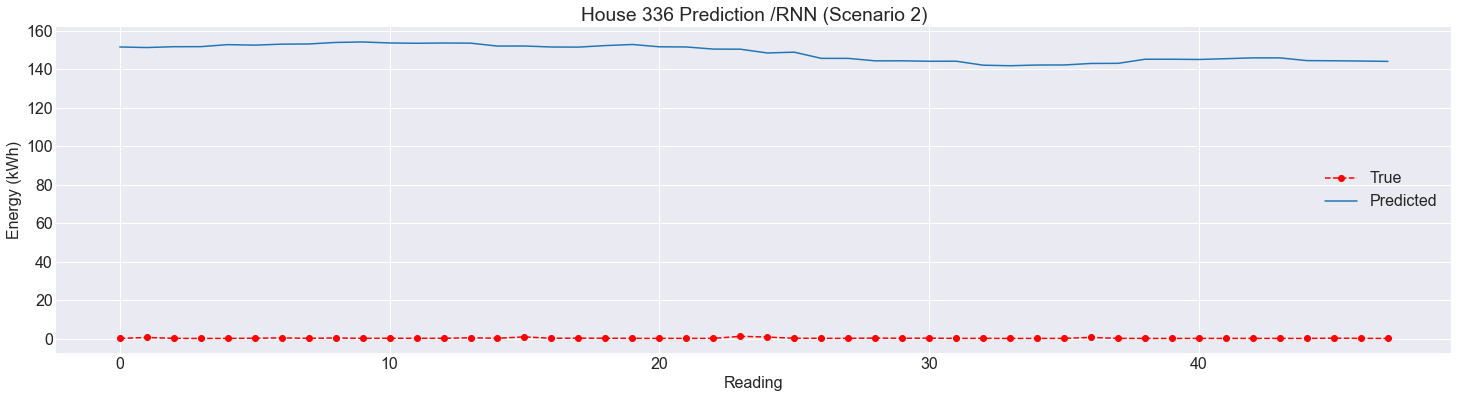

Mse:  1479.924003318482164
Rmse: 38.469780390827317
Mae:  38.234450284857303
Mape:  99.351312094874956


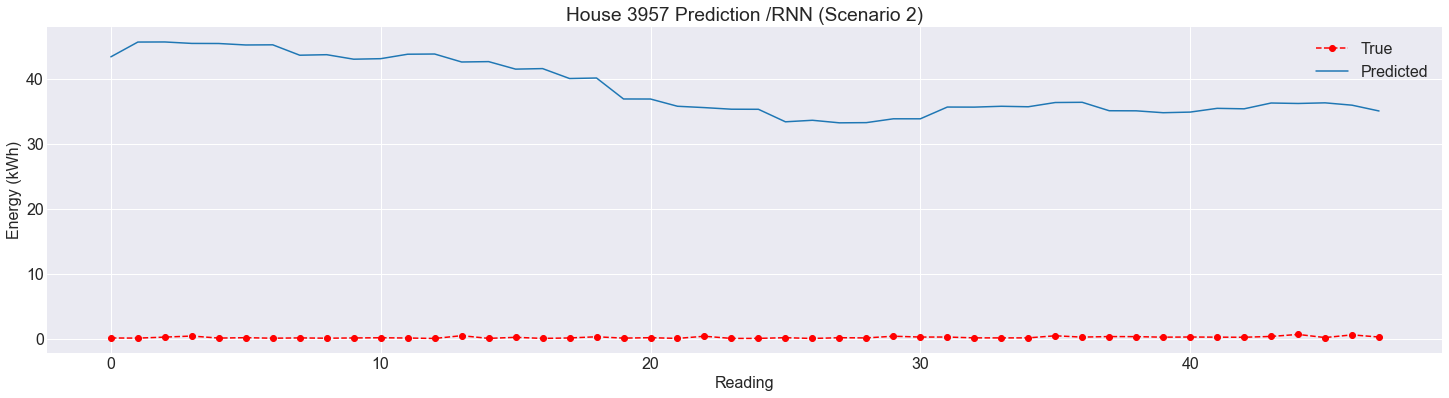

Mse:  13968.189256652374752
Rmse: 118.187094289742035
Mae:  118.176412056510642
Mape:  99.748561250921554


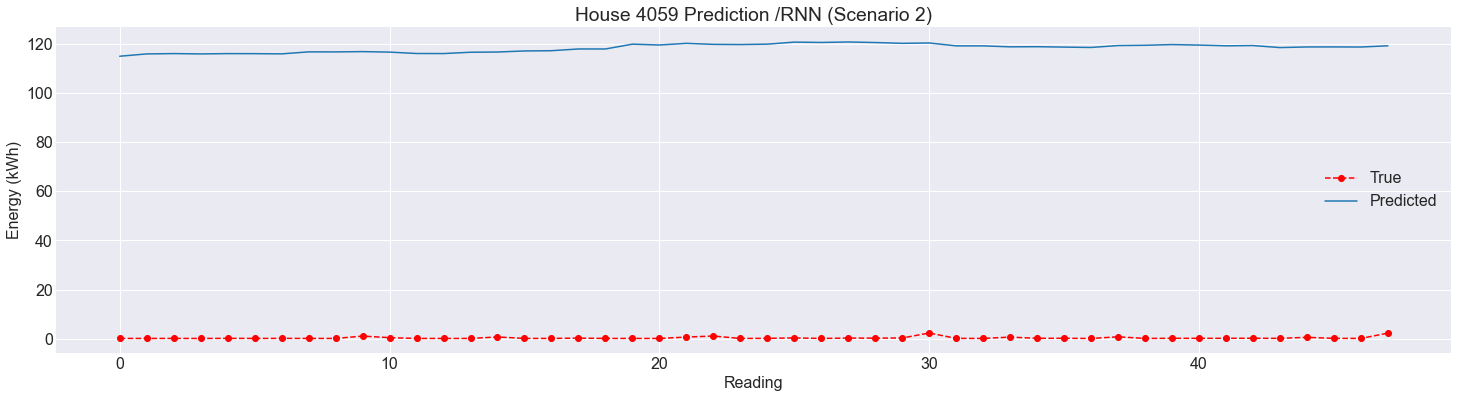

Mse:  21687.872156880766852
Rmse: 147.268028291549996
Mae:  147.231601930999517
Mape:  99.957617933704100


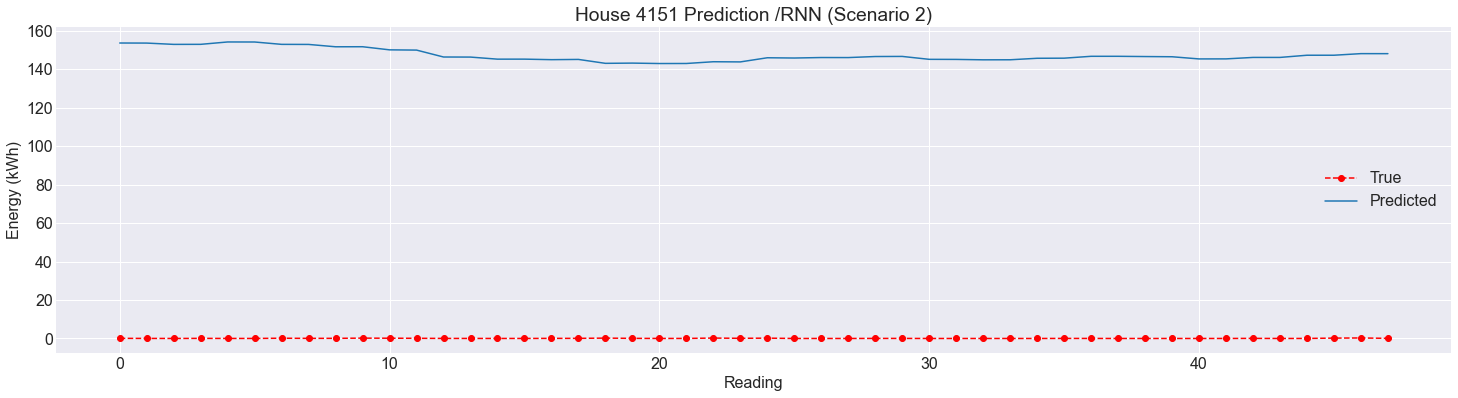

Mse:  2046.091696533502500
Rmse: 45.233745108419917
Mae:  45.227614399511367
Mape:  99.483679325099985


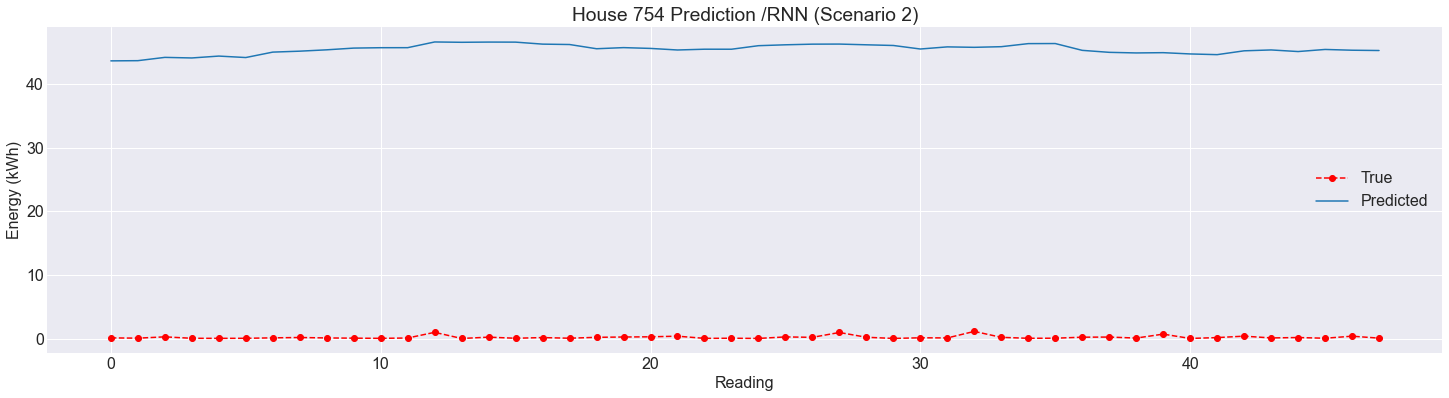

Mse:  9128.485423329841069
Rmse: 95.543107670463812
Mae:  95.439462531435609
Mape:  100.072428112501385


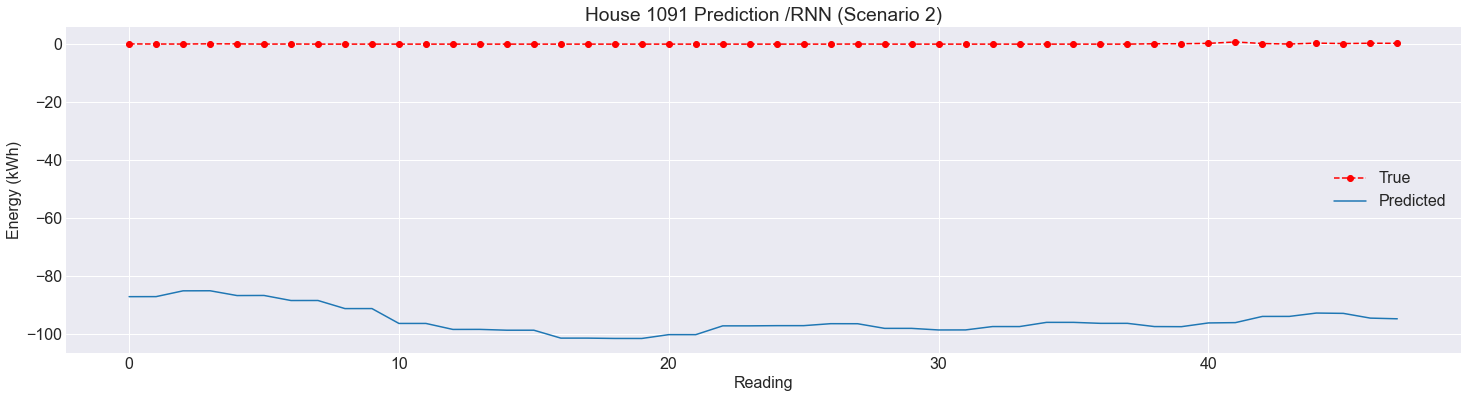

Mse:  13426.043378923786804
Rmse: 115.870804687478483
Mae:  115.860882248608206
Mape:  100.130502745008783


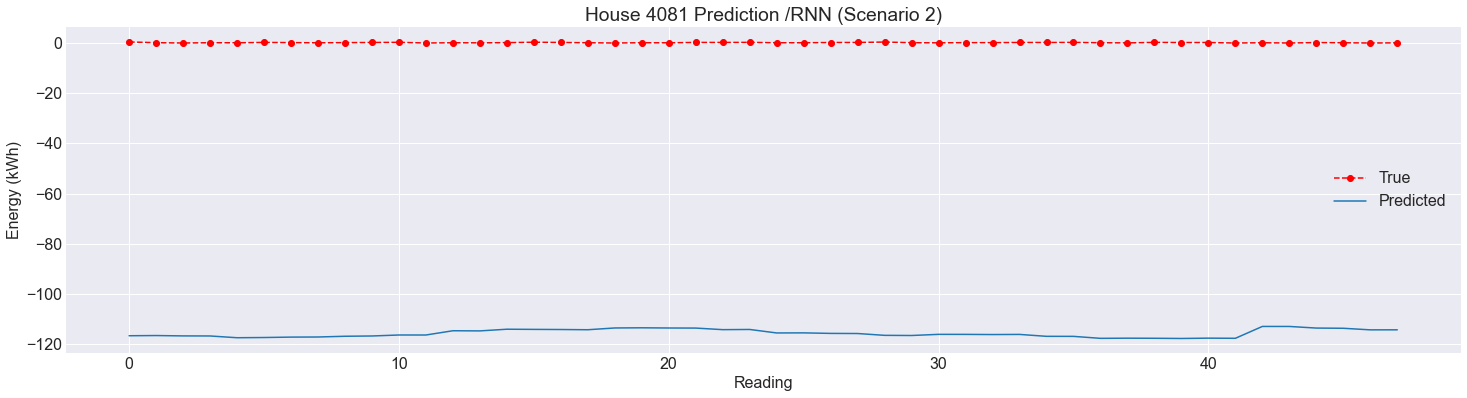

Mse:  9739.273993411008632
Rmse: 98.687760099269696
Mae:  98.641233304360256
Mape:  100.147354242998347


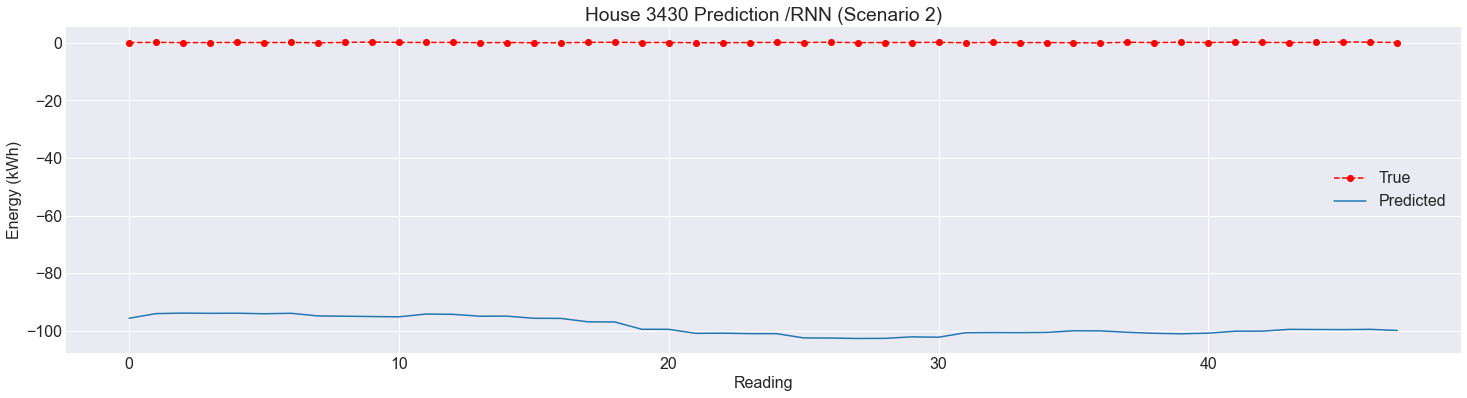

Mse:  3146.979714868641167
Rmse: 56.097947510302383
Mae:  55.990070937511824
Mape:  99.490738900663132


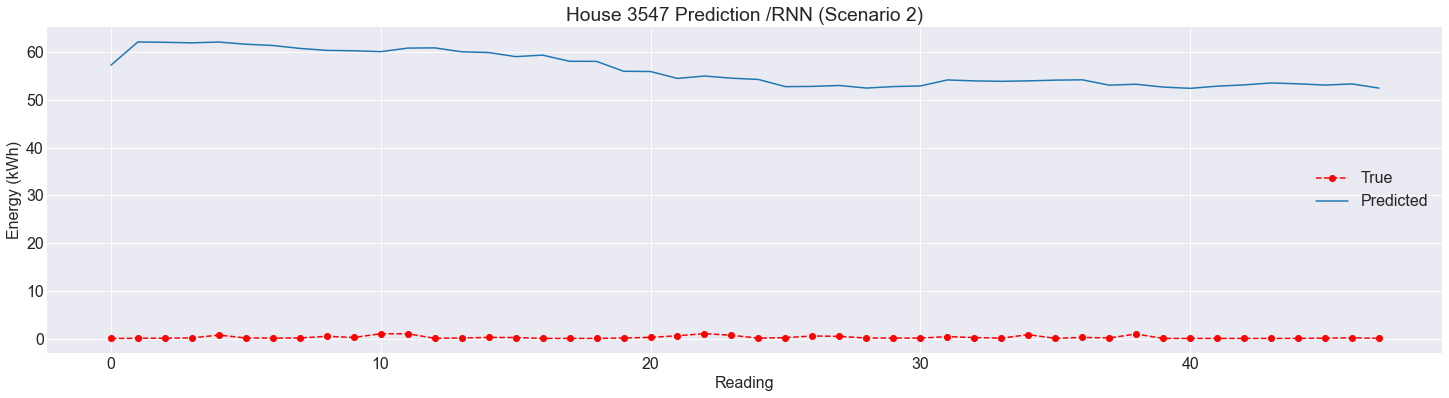

Mse:  2607.001816326755488
Rmse: 51.058807431497613
Mae:  51.054824096422330
Mape:  99.353754438794923


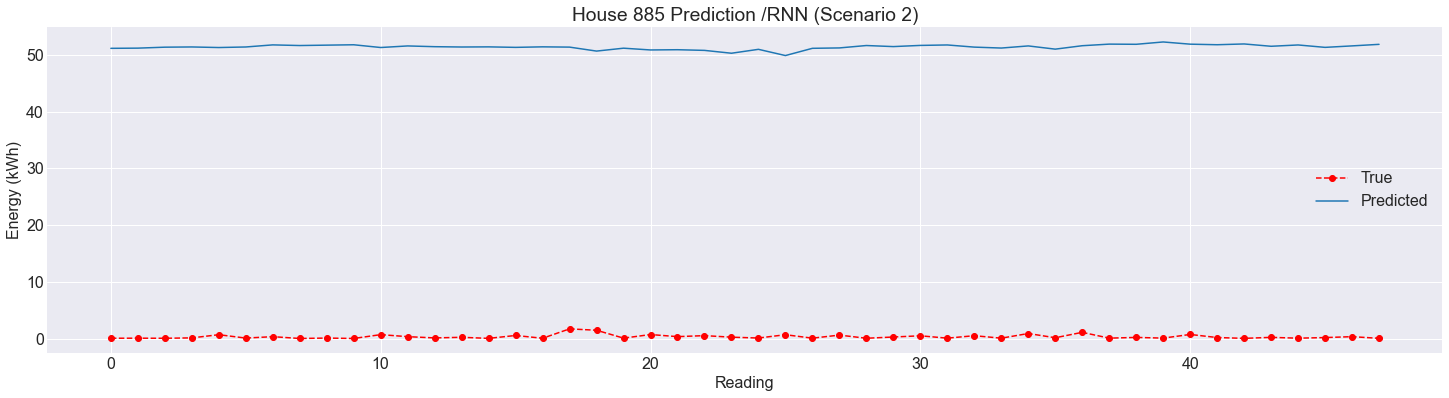

Mse:  129969.300592842511833
Rmse: 360.512552614804974
Mae:  360.509566361472650
Mape:  100.049654325294469


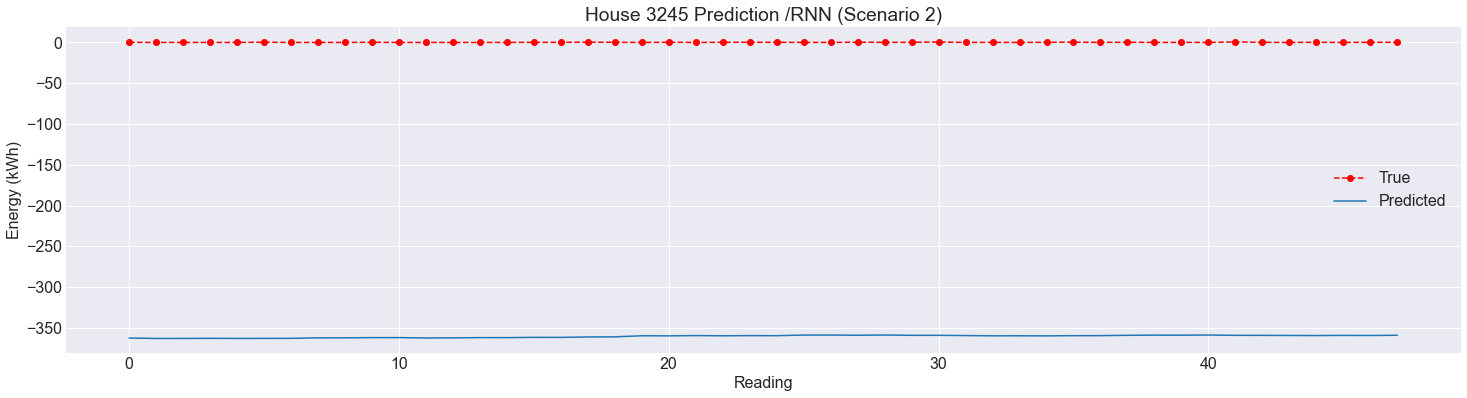

Mse:  32051.123516347695841
Rmse: 179.028275745334980
Mae:  178.847984153932572
Mape:  100.132787975865597


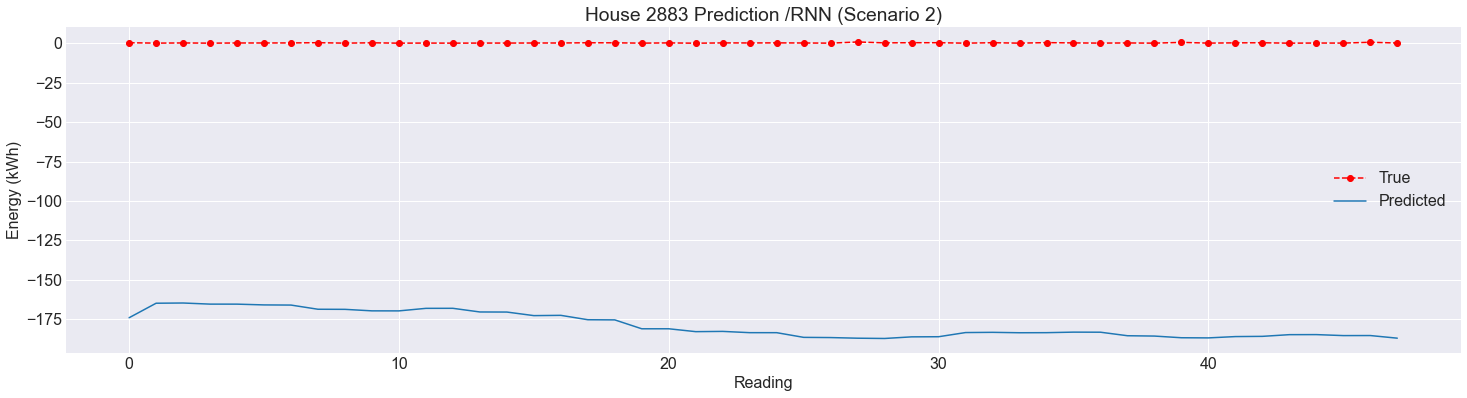

Mse:  130992.292561457885313
Rmse: 361.928573839449541
Mae:  361.922595454360533
Mape:  100.031567001456011


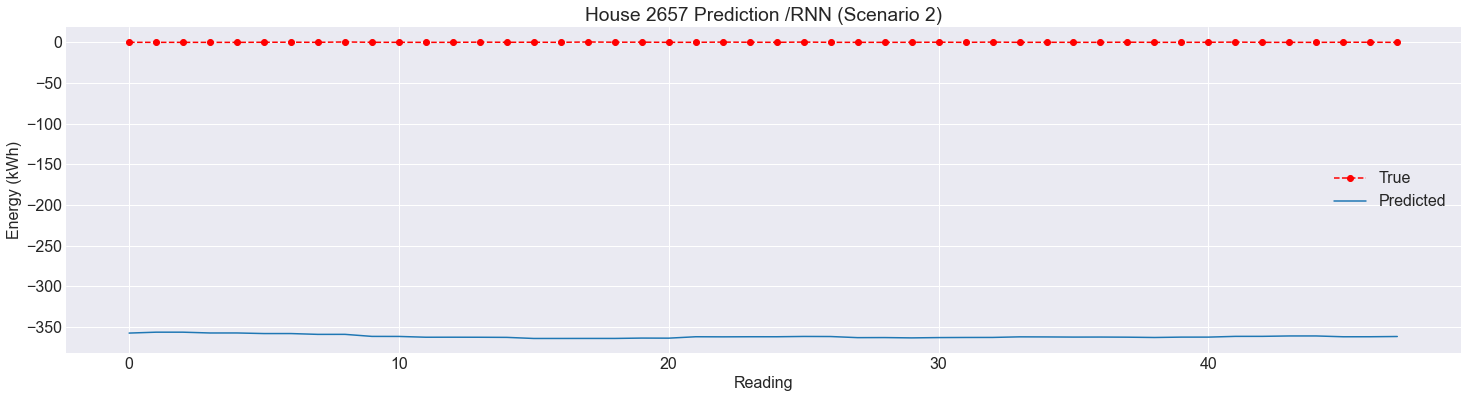

Mse:  821.205176652502473
Rmse: 28.656677697397207
Mae:  28.608460714031633
Mape:  99.575968002631470


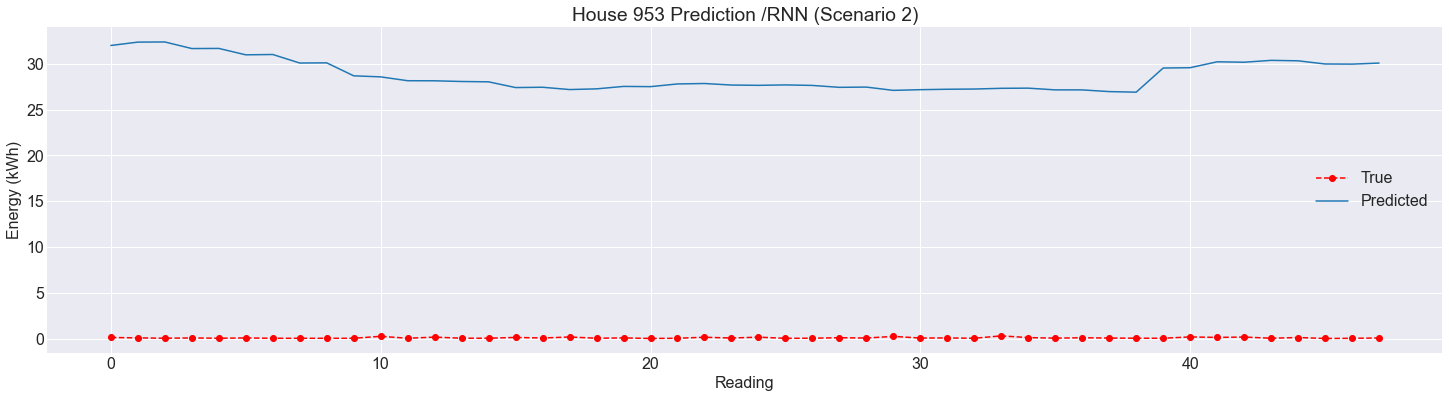

Mse:  8937.076113834691569
Rmse: 94.536110105264498
Mae:  94.288500484700009
Mape:  99.823926647218954


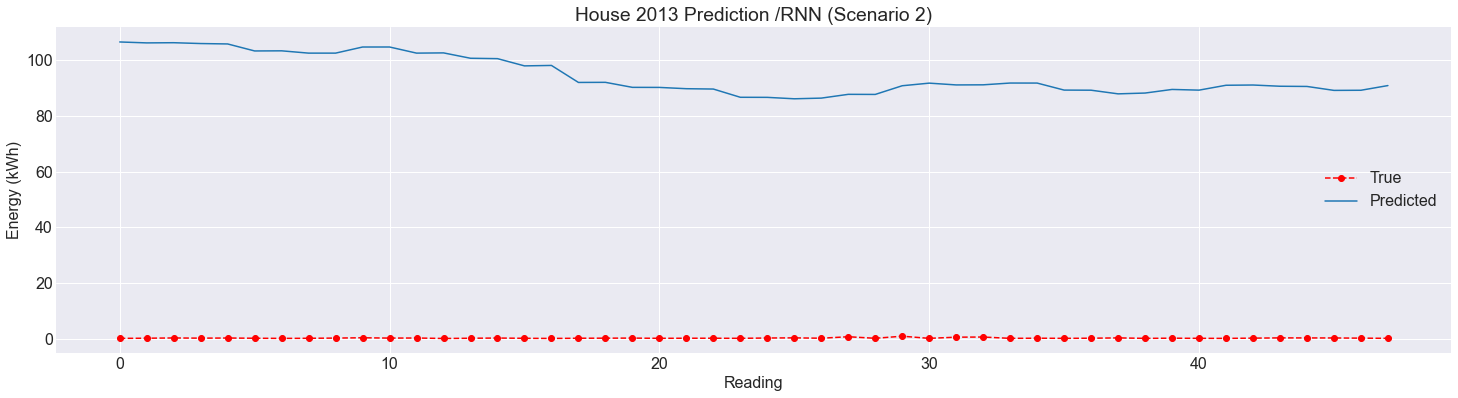

Mse:  28475.074553394591931
Rmse: 168.745591211724985
Mae:  168.743524543630571
Mape:  99.949602479740790


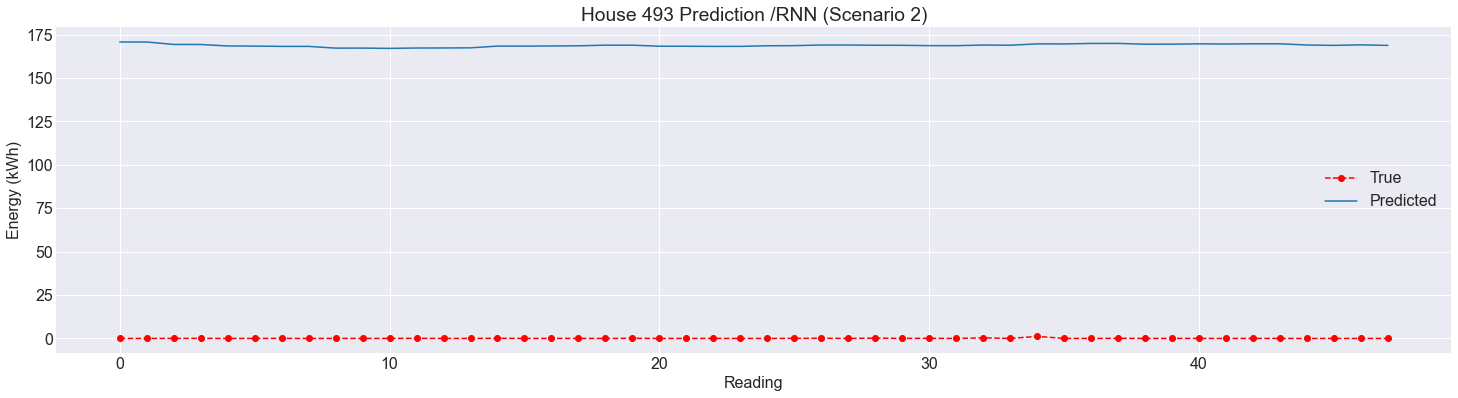

Mse:  17847.805705497605231
Rmse: 133.595679965699503
Mae:  133.593050338948757
Mape:  99.763839571880595


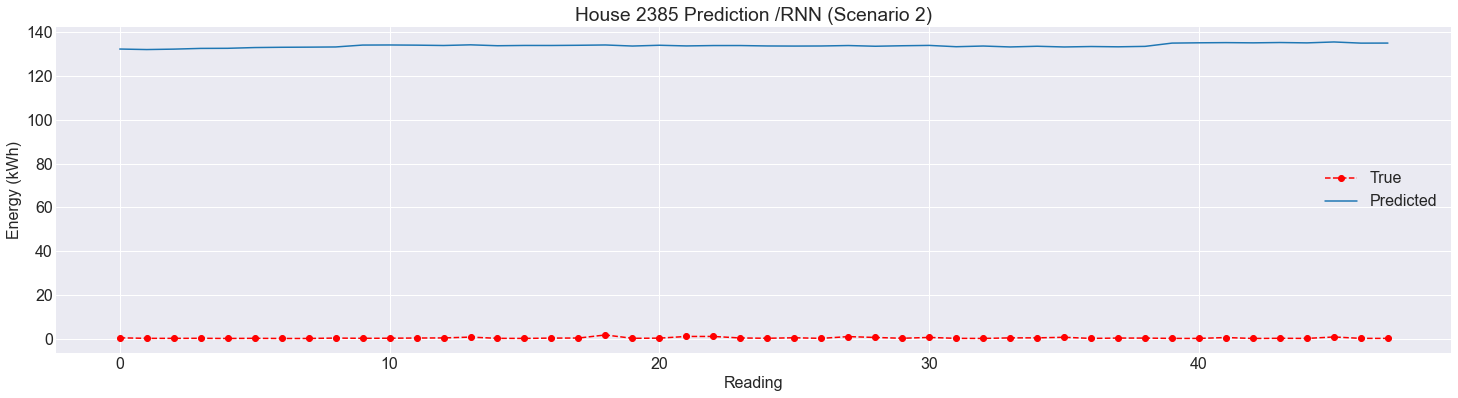

Mse:  115382.346983010414988
Rmse: 339.679771230213873
Mae:  339.674048872121318
Mape:  99.939964193197994


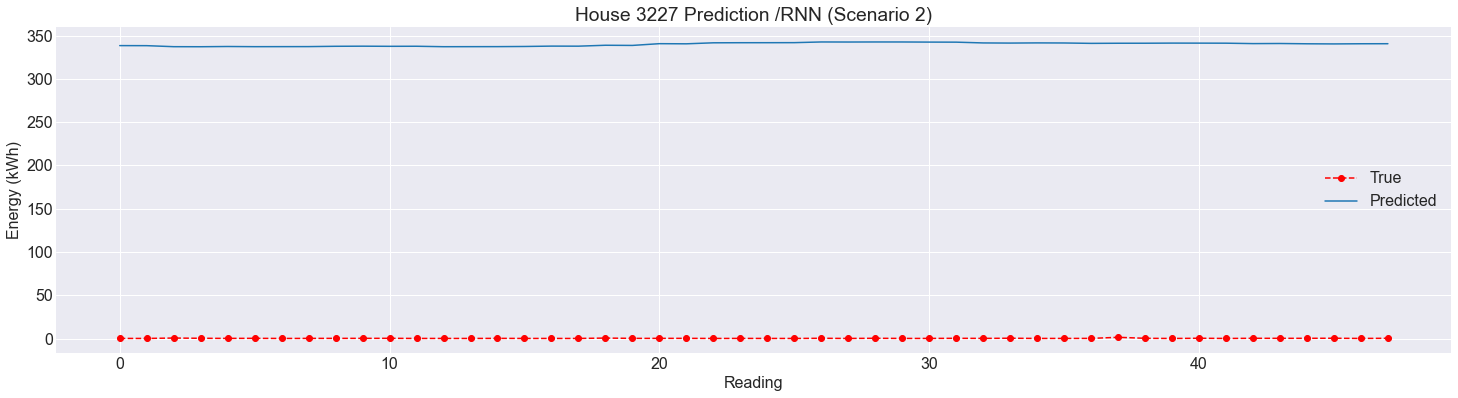

Mse:  157216.125171386054717
Rmse: 396.504886692946116
Mae:  396.503240123934404
Mape:  99.961416758039846


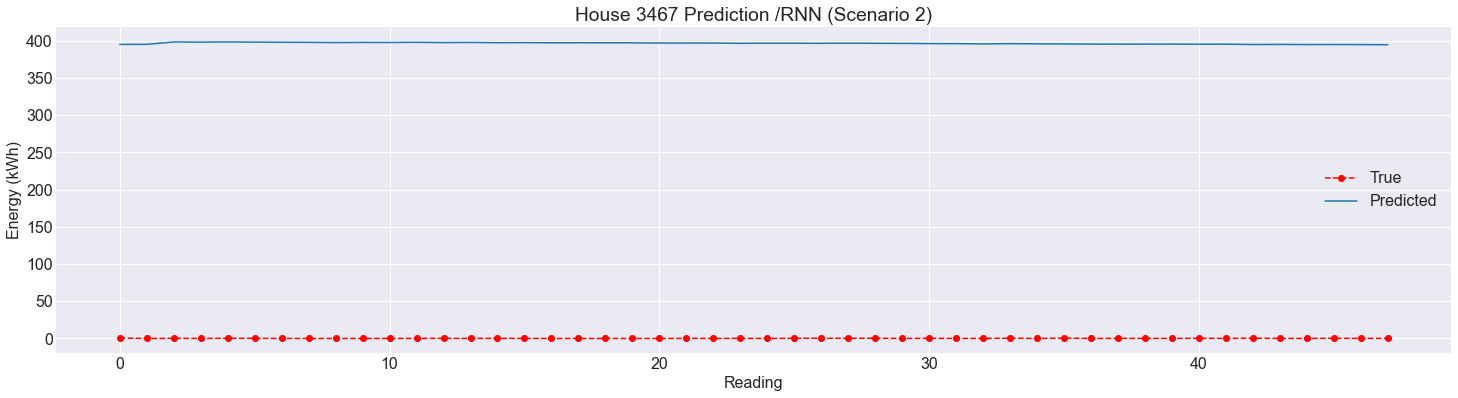

Mse:  140018.813811647240072
Rmse: 374.190878846140834
Mae:  374.108905173372477
Mape:  99.863544435926272


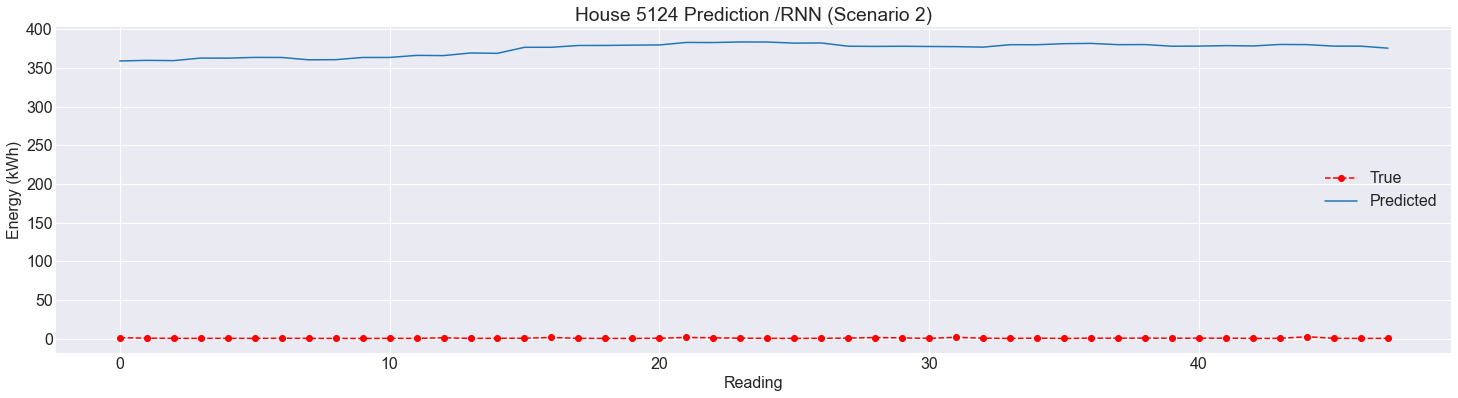

Mse:  49155.794259041926125
Rmse: 221.711060299304705
Mae:  221.709694219442696
Mape:  100.176887274944775


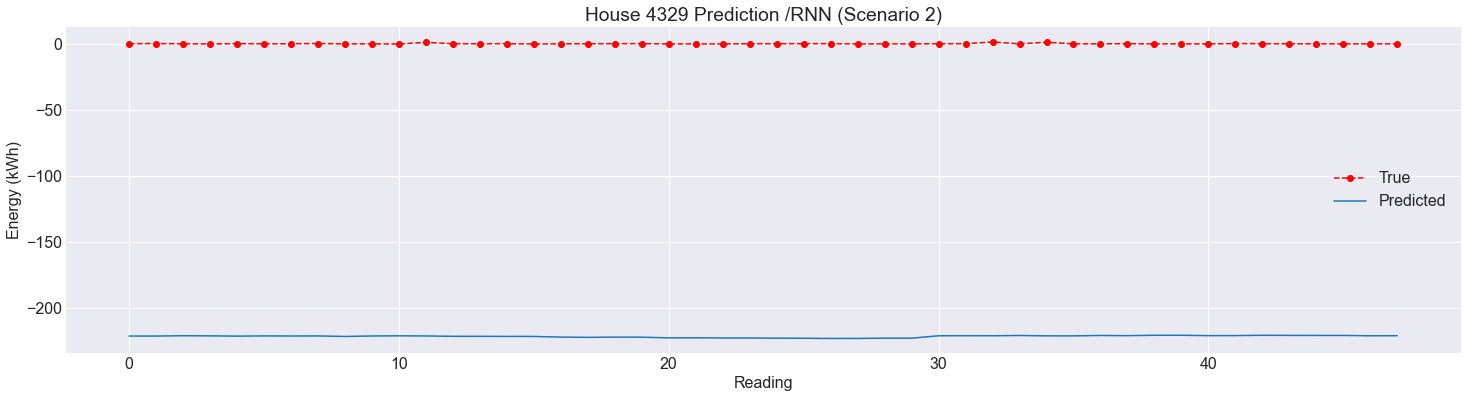

In [104]:
 ##### The households with an error have a '#' 


predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)



In [ ]:
models_performances_HH_level = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level

,HH_1,HH_2,HH_3,HH_4,HH_5,HH_6,HH_7,HH_8,HH_9,HH_10,...,HH_20,HH_21,HH_22,HH_23,HH_24,HH_25,HH_26,HH_27,HH_28,HH_29
MSE_scores,15202.189252,41178.614757,8438.187943,9729.816787,1224.573983,8535.518676,21138.681356,2020.987769,4855.140220,1098.080809,...,4374.040655,32869.372371,1533.716503,1686.220103,12246.443959,878.146015,10400.986747,10078.776716,19598.836397,497.646839
RMSE_scores,123.297158,202.925146,91.859610,98.639834,34.993914,92.387871,145.391476,44.955398,69.678836,33.137302,...,66.136530,181.299124,39.162693,41.063610,110.663652,29.633529,101.985228,100.393111,139.995844,22.307999
MAE_scores,123.281726,202.898766,91.667793,98.430019,34.855197,92.376034,145.388691,44.952364,69.640860,33.131443,...,66.122475,181.258078,38.877429,41.050250,110.596898,29.596180,101.978990,100.363487,139.989482,22.297821
MAPE_scores,100.138849,100.120546,100.778952,100.149224,99.814049,100.176131,100.240776,100.205807,99.813000,100.778789,...,99.603787,100.061799,99.684018,99.566595,100.099451,98.897944,99.804710,100.153562,99.587808,101.586089


In [ ]:
models_performances_HH_level.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario2.csv', index=False)

In [ ]:
## Best regression model

In [ ]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                      'HH_2',
                      'HH_3',
                      'HH_4',
                      'HH_5',
                      'HH_6',
                      'HH_7',
                      'HH_8',
                      'HH_9',
                      'HH_10',
                      'HH_11',
                      'HH_12',
                      'HH_13',
                      'HH_14',
                      'HH_15',
                      'HH_16',
                      'HH_17',
                      'HH_18',
                      'HH_19',
                      'HH_20',
                      'HH_21',
                      'HH_22',
                      'HH_23',
                      'HH_24',
                      'HH_25',
                      'HH_26',
                      'HH_27',
                      'HH_28', 
                      'HH_29']

In [105]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-48), :]
  test = reframed[(len(reframed)-48):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]


  model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
  model.fit(train_X, train_y)

  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15f}')
  print(f'Rmse: {rmse_HH:.15f}')
  print(f'Mae:  {mae_HH:.15f}')
  print(f'Mape:  {mape_HH:.15f}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /SVR (Scenario 2)')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario2/2_singleHouseholdLevel/best_regression_model/S2_24h_SVR_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


In [106]:
 ##### The households with an error have a '#' 


predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
models_performances_HH_level_Regression = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level_Regression

,HH_1,HH_2,HH_3,HH_4,HH_5,HH_6,HH_7,HH_8,HH_9,HH_10,...,HH_20,HH_21,HH_22,HH_23,HH_24,HH_25,HH_26,HH_27,HH_28,HH_29
MSE_scores,0.039830,0.374876,0.267042,0.018457,0.005334,0.182810,0.592002,0.006040,0.326848,0.200396,...,0.129234,0.069294,0.004228,0.041426,0.047013,0.098913,0.048692,0.057832,0.537610,0.065148
RMSE_scores,0.199574,0.612271,0.516761,0.135857,0.073032,0.427563,0.769417,0.077716,0.571706,0.447657,...,0.359491,0.263238,0.065021,0.203533,0.216824,0.314504,0.220663,0.240484,0.733219,0.255242
MAE_scores,0.175535,0.561504,0.387589,0.089798,0.044171,0.370807,0.676141,0.067534,0.412537,0.381156,...,0.280750,0.236913,0.052066,0.137891,0.101421,0.232547,0.144439,0.208230,0.603064,0.167370
MAPE_scores,52.759190,1073.635109,153.349790,80.909491,86.971698,516.191940,485.233931,208.803718,143.021577,374.957677,...,196.197971,67.806901,41.718127,475.556363,226.134753,141.722998,50.944813,358.991230,96.422901,83.329222


In [ ]:
models_performances_HH_level_Regression.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario2_SVR.csv', index=False)